#  _Employee Attrition Project_

# Antonio Bisegna 4803829





In [450]:
import pandas as pd
import numpy as np
import datetime as dt
import sqlite3
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.pipeline import Pipeline

%matplotlib inline

## Data Retrieving

In [451]:
pwd

'/Users/antoniobisegna/Desktop/Data mining/project'

In [452]:
df_base = pd.read_csv('/Users/EmployeeAttrition.csv')

In [453]:
df_base.shape

(49653, 18)

In [ ]:
df_base.describe(include='all')

In [455]:
df_base.dtypes

EmployeeID              int64
recorddate_key         object
birthdate_key          object
orighiredate_key       object
terminationdate_key    object
age                     int64
length_of_service       int64
city_name              object
department_name        object
job_title              object
store_name              int64
gender_short           object
gender_full            object
termreason_desc        object
termtype_desc          object
STATUS_YEAR             int64
STATUS                 object
BUSINESS_UNIT          object
dtype: object

In [456]:
# we can see that some variables are misstyped but they are not.
# Specifically I am speaking about the recorddate_key, birthdate_key, orighiredate_key,
# terminationdate_key, STATUS_YEAR that are actually part of another type of variable: date.

df_base = pd.read_csv('/Users/antoniobisegna/Desktop/Data mining/Projects_data/EmployeeAttrition.csv',
                           parse_dates=['recorddate_key','birthdate_key','orighiredate_key','terminationdate_key','STATUS_YEAR'], 
                           dtype={'EmployeeID':str, 'store_name':str})
df_base.dtypes

EmployeeID                     object
recorddate_key         datetime64[ns]
birthdate_key          datetime64[ns]
orighiredate_key       datetime64[ns]
terminationdate_key    datetime64[ns]
age                             int64
length_of_service               int64
city_name                      object
department_name                object
job_title                      object
store_name                     object
gender_short                   object
gender_full                    object
termreason_desc                object
termtype_desc                  object
STATUS_YEAR            datetime64[ns]
STATUS                         object
BUSINESS_UNIT                  object
dtype: object

In [457]:
df_base.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,gender_full,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,2006-12-31,1954-01-03,1989-08-28,1900-01-01,52,17,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2006-01-01,ACTIVE,HEADOFFICE
1,1318,2007-12-31,1954-01-03,1989-08-28,1900-01-01,53,18,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2007-01-01,ACTIVE,HEADOFFICE
2,1318,2008-12-31,1954-01-03,1989-08-28,1900-01-01,54,19,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2008-01-01,ACTIVE,HEADOFFICE
3,1318,2009-12-31,1954-01-03,1989-08-28,1900-01-01,55,20,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2009-01-01,ACTIVE,HEADOFFICE
4,1318,2010-12-31,1954-01-03,1989-08-28,1900-01-01,56,21,Vancouver,Executive,CEO,35,M,Male,Not Applicable,Not Applicable,2010-01-01,ACTIVE,HEADOFFICE


In [458]:
# Just by looking at the dataframe we can remove the variable gender_full since there is already
# the gender_short variable
df_base.drop(['gender_full'], 1, inplace=True)

# Retrieving and exploration of data

Simply by carefully observing the variables and knowing what is the objective of the analysis we have to target the variable that explains the position of the employee with respect to the company.

We start from the visualization of these kind of variables since they could give some basic highlines to follow for a better analysis.

## Visualization

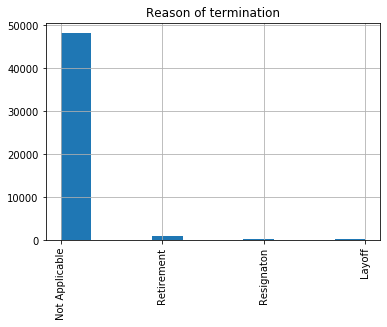

In [459]:
# Reason of termination
plt.figure()

df_base['termreason_desc'].hist()

plt.xticks(rotation='vertical')
plt.title('Reason of termination')
plt.show()

First of all it would be easier to understand their pattern if we would consider just the workers that are already out of the company and what pushed them to loose their job.

In [460]:
df_base1 = df_base[df_base.termreason_desc != 'Not Applicable']


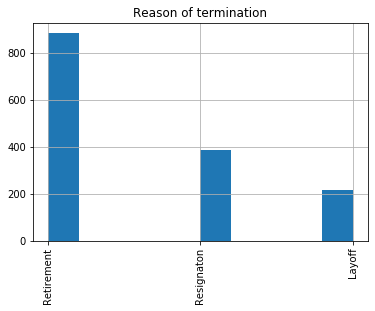

In [560]:
plt.figure()

df_base1['termreason_desc'].hist()

plt.xticks(rotation='vertical')
plt.title('Reason of termination')
plt.show()

What we can see is that the main reason why people leave their job is retirement.

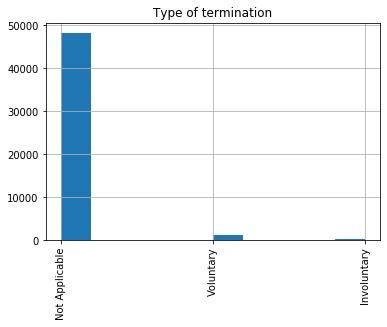

In [462]:
# Type of termination
plt.figure()

df_base['termtype_desc'].hist()

plt.xticks(rotation='vertical')
plt.title('Type of termination')
plt.show()

In [463]:
df_base2 = df_base1[df_base1.termtype_desc != 'Not Applicable']

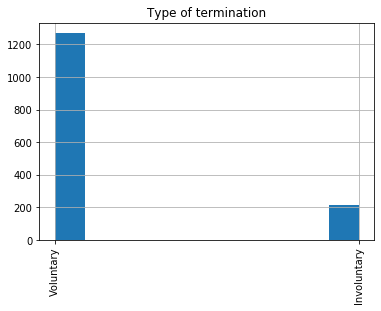

In [464]:
plt.figure()

df_base2['termtype_desc'].hist()

plt.xticks(rotation='vertical')
plt.title('Type of termination')
plt.show()

Most of the endings of the contracts are voluntary, as we would have expected also from the analysis of the 'type of termination' variable.


* This analysis of the variables 'Type of termination' and 'Reason of termination' will be useful later for the feature analysis

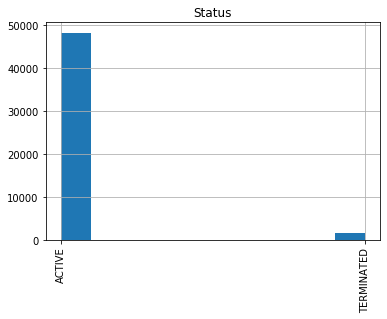

In [465]:
# STATUS
plt.figure()

df_base['STATUS'].hist()

plt.xticks(rotation='vertical')
plt.title('Status')
plt.show()

We can make the assumption that the target of the analysis lays in the STATUS variable since it is easy to retrieve but at the same time explanatory enough.
The other two variables are highly connected to the STATUS one and we can see them as sub-categories to it.

Since STATUS has two possible outcomes, ACTIVE and TERMINATED, we can transform this variable from categorical to numerical using the *replace* method:

In [466]:
df_base['STATUS'].replace({'TERMINATED': 0, 'ACTIVE': 1}, inplace=True)
df_base.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
0,1318,2006-12-31,1954-01-03,1989-08-28,1900-01-01,52,17,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2006-01-01,1,HEADOFFICE
1,1318,2007-12-31,1954-01-03,1989-08-28,1900-01-01,53,18,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2007-01-01,1,HEADOFFICE
2,1318,2008-12-31,1954-01-03,1989-08-28,1900-01-01,54,19,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2008-01-01,1,HEADOFFICE
3,1318,2009-12-31,1954-01-03,1989-08-28,1900-01-01,55,20,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2009-01-01,1,HEADOFFICE
4,1318,2010-12-31,1954-01-03,1989-08-28,1900-01-01,56,21,Vancouver,Executive,CEO,35,M,Not Applicable,Not Applicable,2010-01-01,1,HEADOFFICE


In [467]:
# In order to have a parameter to use for comparing the active members and the non-active workers I chose to 
# remove the different repetitions of EmployeeID and have just one per last registration date. 
df_base= df_base.sort_values('recorddate_key').drop_duplicates('EmployeeID',keep='last')
df_base.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,termreason_desc,termtype_desc,STATUS_YEAR,STATUS,BUSINESS_UNIT
48424,2304,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,Vernon,Meats,Meat Cutter,36,F,Retirement,Voluntary,2006-01-01,0,STORES
48812,4118,2006-01-01,1946-01-23,1997-07-31,2006-01-23,60,8,Vancouver,Meats,Meat Cutter,35,M,Retirement,Voluntary,2006-01-01,0,STORES
48423,2303,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,New Westminster,Meats,Meat Cutter,21,F,Retirement,Voluntary,2006-01-01,0,STORES
48811,4116,2006-01-01,1946-01-22,1997-07-30,2006-01-22,60,8,Richmond,Produce,Produce Clerk,29,M,Retirement,Voluntary,2006-01-01,0,STORES
48808,4110,2006-01-01,1946-01-16,1997-07-24,2006-01-16,60,8,Surrey,Produce,Produce Clerk,31,M,Retirement,Voluntary,2006-01-01,0,STORES


In [468]:
# now we can see the percentage of Active/Past employees over the number of employees
df_base.groupby('STATUS')[['EmployeeID']].count() / df_base.shape[0]

,EmployeeID
STATUS,
0,0.235519
1,0.764481


In [469]:
# Starting from:
df_base.groupby(['STATUS', 'termtype_desc']).count()

EmployeeID  recorddate_key  birthdate_key  \
STATUS termtype_desc                                               
0      Involuntary            215             215            215   
       Voluntary             1265            1265           1265   
1      Not Applicable        4804            4804           4804   

                       orighiredate_key  terminationdate_key   age  \
STATUS termtype_desc                                                 
0      Involuntary                  215                  215   215   
       Voluntary                   1265                 1265  1265   
1      Not Applicable              4804                 4804  4804   

                       length_of_service  city_name  department_name  \
STATUS termtype_desc                                                   
0      Involuntary                   215        215              215   
       Voluntary                    1265       1265             1265   
1      Not Applicable               4804       4804             4804   

                       job_title  store_name  gender_short  termreason_desc  \
STATUS termtype_desc                                                          
0      Involuntary           215         215           215              215   
       Voluntary            1265        1265          1265             1265   
1      Not Applicable       4804        4804          4804             4804   

                       STATUS_YEAR  BUSINESS_UNIT  
STATUS termtype_desc                               
0      Involuntary             215            215  
       Voluntary              1265           1265  
1      Not Applicable         4804           4804

In [470]:
df_base.groupby(['STATUS', 'termreason_desc']).count()

EmployeeID  recorddate_key  birthdate_key  \
STATUS termreason_desc                                              
0      Layoff                  215             215            215   
       Resignaton              382             382            382   
       Retirement              883             883            883   
1      Not Applicable         4804            4804           4804   

                        orighiredate_key  terminationdate_key   age  \
STATUS termreason_desc                                                
0      Layoff                        215                  215   215   
       Resignaton                    382                  382   382   
       Retirement                    883                  883   883   
1      Not Applicable               4804                 4804  4804   

                        length_of_service  city_name  department_name  \
STATUS termreason_desc                                                  
0      Layoff                         215        215              215   
       Resignaton                     382        382              382   
       Retirement                     883        883              883   
1      Not Applicable                4804       4804             4804   

                        job_title  store_name  gender_short  termtype_desc  \
STATUS termreason_desc                                                       
0      Layoff                 215         215           215            215   
       Resignaton             382         382           382            382   
       Retirement             883         883           883            883   
1      Not Applicable        4804        4804          4804           4804   

                        STATUS_YEAR  BUSINESS_UNIT  
STATUS termreason_desc                              
0      Layoff                   215            215  
       Resignaton               382            382  
       Retirement               883            883  
1      Not Applicable          4804           4804

In [471]:
# In order to simplify our analysis we can remove the variables termreason_desc and termtype_desc 
# since they are just specifications of what is said in the STATUS variable 
# At least if we consider the objective of our analysis
df_base.drop(['termreason_desc', 'termtype_desc'], 1, inplace=True) 
df_base.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS_YEAR,STATUS,BUSINESS_UNIT
48424,2304,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,Vernon,Meats,Meat Cutter,36,F,2006-01-01,0,STORES
48812,4118,2006-01-01,1946-01-23,1997-07-31,2006-01-23,60,8,Vancouver,Meats,Meat Cutter,35,M,2006-01-01,0,STORES
48423,2303,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,New Westminster,Meats,Meat Cutter,21,F,2006-01-01,0,STORES
48811,4116,2006-01-01,1946-01-22,1997-07-30,2006-01-22,60,8,Richmond,Produce,Produce Clerk,29,M,2006-01-01,0,STORES
48808,4110,2006-01-01,1946-01-16,1997-07-24,2006-01-16,60,8,Surrey,Produce,Produce Clerk,31,M,2006-01-01,0,STORES


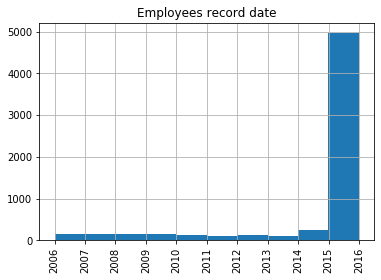

In [472]:
# Now we keep visualizing other variables
# starting from record date

plt.figure()
df_base['recorddate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Employees record date")
plt.show()

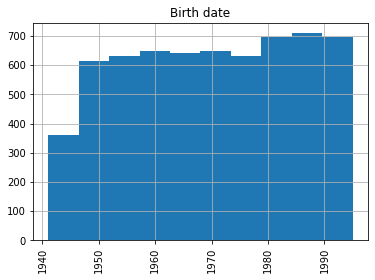

In [473]:
# Birth date 
plt.figure()
df_base['birthdate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Birth date")
plt.show()

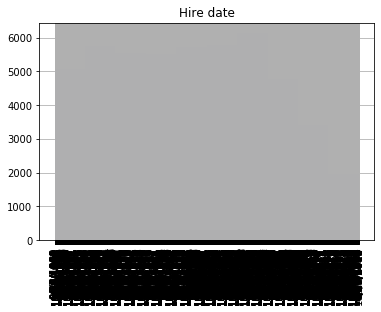

In [474]:
# original hire date
plt.figure()
df_employees['orighiredate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Hire date")
plt.show()

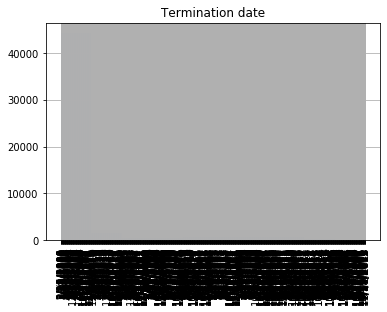

In [475]:
# for the termination date we should substitute 1900-01-01 with NaN since probably it corresponds to 
# the employees that are still active
df_base.loc[df_base['terminationdate_key'] == pd.to_datetime('1900-01-01'), 'terminationdate_key'] = np.nan

# then
plt.figure()
df_employees['terminationdate_key'].hist()
plt.xticks(rotation='vertical')
plt.title("Termination date")
plt.show()

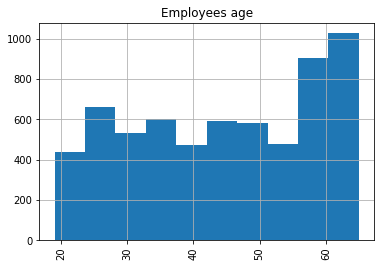

In [476]:
# age
plt.figure()
df_base['age'].hist()
plt.xticks(rotation='vertical')
plt.title("Employees age")
plt.show()

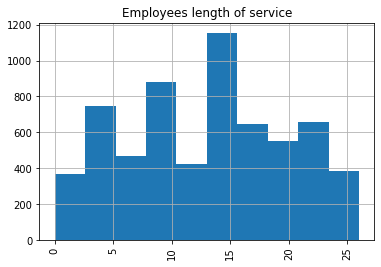

In [477]:
# lenght of service
plt.figure()
df_base['length_of_service'].hist()
plt.xticks(rotation='vertical')
plt.title("Employees length of service")
plt.show()

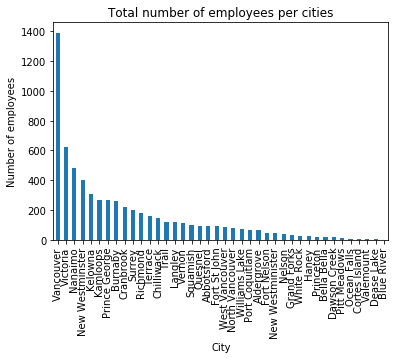

In [478]:
# for the qualitative variables such as 'city' we firstly use counts() and then use 

employees_per_city = df_base['city_name'].value_counts()

employees_per_city.plot(kind='bar')
plt.xlabel('City')
plt.ylabel('Number of employees')
plt.title("Total number of employees per cities")
plt.show()

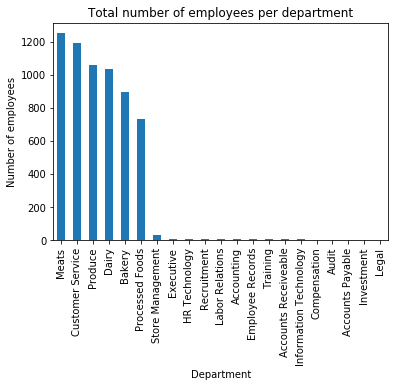

In [479]:
employees_per_department = df_base['department_name'].value_counts() 

employees_per_department.plot(kind='bar')
plt.xlabel('Department')
plt.ylabel('Number of employees')
plt.title("Total number of employees per department")
plt.show()

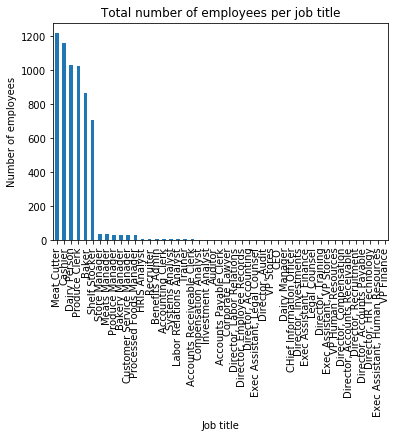

In [480]:
employees_per_jobtitle= df_base['job_title'].value_counts()
employees_per_jobtitle.plot(kind='bar')
plt.xlabel('Job title')
plt.ylabel('Number of employees')
plt.title("Total number of employees per job title")
plt.show()

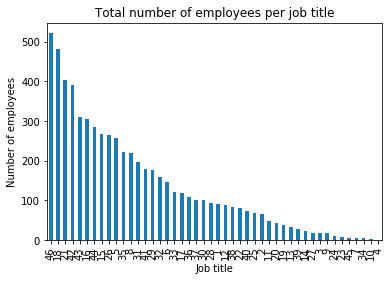

In [481]:
employees_per_storename = df_base['store_name'].value_counts()

employees_per_storename.plot(kind='bar')
plt.xlabel('Job title')
plt.ylabel('Number of employees')
plt.title("Total number of employees per job title")
plt.show()

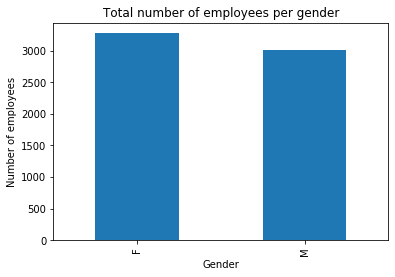

In [482]:
# visualize male and female employees:
employees_gender = df_base['gender_short'].value_counts() 

employees_gender.plot(kind='bar')
plt.xlabel('Gender')
plt.ylabel('Number of employees')
plt.title("Total number of employees per gender")
plt.show()

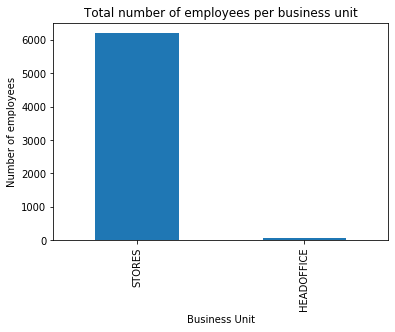

In [483]:
# business unit
employees_businessunit = df_base['BUSINESS_UNIT'].value_counts() 

employees_businessunit.plot(kind='bar')
plt.xlabel('Business Unit')
plt.ylabel('Number of employees')
plt.title("Total number of employees per business unit")
plt.show()

In [484]:
# since the division in the business unit variable is pretty irrelevant we could drop it
df_base.drop(['BUSINESS_UNIT'], 1, inplace=True)
df_base.head()

,EmployeeID,recorddate_key,birthdate_key,orighiredate_key,terminationdate_key,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS_YEAR,STATUS
48424,2304,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,Vernon,Meats,Meat Cutter,36,F,2006-01-01,0
48812,4118,2006-01-01,1946-01-23,1997-07-31,2006-01-23,60,8,Vancouver,Meats,Meat Cutter,35,M,2006-01-01,0
48423,2303,2006-01-01,1941-01-15,1992-07-22,2006-01-15,65,13,New Westminster,Meats,Meat Cutter,21,F,2006-01-01,0
48811,4116,2006-01-01,1946-01-22,1997-07-30,2006-01-22,60,8,Richmond,Produce,Produce Clerk,29,M,2006-01-01,0
48808,4110,2006-01-01,1946-01-16,1997-07-24,2006-01-16,60,8,Surrey,Produce,Produce Clerk,31,M,2006-01-01,0


In [485]:
# After this first analysis, we can drop some columns. 
# We get rid of the date time objects:
df_base.drop(['EmployeeID', 'recorddate_key', 'birthdate_key','orighiredate_key','terminationdate_key','STATUS_YEAR'], 1, inplace=True) 

df_base.head()

,age,length_of_service,city_name,department_name,job_title,store_name,gender_short,STATUS
48424,65,13,Vernon,Meats,Meat Cutter,36,F,0
48812,60,8,Vancouver,Meats,Meat Cutter,35,M,0
48423,65,13,New Westminster,Meats,Meat Cutter,21,F,0
48811,60,8,Richmond,Produce,Produce Clerk,29,M,0
48808,60,8,Surrey,Produce,Produce Clerk,31,M,0


## Feature analysis

After some 'cleaning' we try to set the trend of the STATUS target variable with respect to the other selected variables.
Since the target variable has two possible outcomes we can try to find any difference between the relationship of the independent variables with respect to the STATUS variable.
i.e. there is a different percentage of Male/Female active employees compared to the Male/Female ex employees.
In order to do so we create two different dataframes 'df_active' and 'df_past' from the STATUS variable and then we study the trend of each variable with respect to those two levels of the target.

In [486]:
df_active=df_base[df_base['STATUS']==1]
df_past=df_base[df_base['STATUS']==0]

print('The number of active employees is: ',len(df_active))
print('The number of past employees is: ',len(df_past))

The number of active employees is:  4804
The number of past employees is:  1480


In [487]:
# Age trend (Active employees)
active_age = df_active['age'].value_counts().to_frame().reset_index()
active_age.rename(columns={'index':'age','age':'count'},inplace=True)
num_active=len(df_active)
active_age

,age,count
0,36,133
1,24,132
2,56,130
3,51,127
4,53,125
5,46,122
6,27,122
7,59,121
8,55,120
9,43,117


In [488]:
# Age trend (Past employees)
past_age = df_past['age'].value_counts().to_frame().reset_index()
past_age.rename(columns={'index':'age','age':'count'},inplace=True)
num_past=len(df_past)
past_age

,age,count
0,65,589
1,60,296
2,30,81
3,21,66
4,23,38
5,24,33
6,22,32
7,64,18
8,25,18
9,32,17


As expected mostly the employees who leave the company are older than 60, which may reflect also what we saw above when studying the distribution of 'Reason of termination':
the high number of people that leave their job because of retirement.
For the Active employees we can see that the distribution seems pretty 'natural'.

In [489]:
# LoS trend (Active)
active_lof=df_active['length_of_service'].value_counts().to_frame().reset_index()
active_lof.rename(columns={'index':'length of service','length_of_service':'count'},inplace=True)
num_active = len(df_active)
active_lof.head()

,length of service,count
0,20,237
1,10,237
2,15,229
3,3,223
4,18,219


In [490]:
active_lof.mean()

length of service     13.000000
count                177.925926
dtype: float64

In [491]:
# LoS trend (Past)
past_lof = df_past['length_of_service'].value_counts().to_frame().reset_index()
past_lof.rename(columns={'index':'length of service','length_of_service':'count'},inplace=True)
num_past = len(df_past)
past_lof.head()

,length of service,count
0,13,483
1,8,218
2,1,135
3,24,79
4,19,76


In [492]:
past_lof.mean()


length of service    12.500000
count                56.923077
dtype: float64

The lenght of service for both active and past employees is more or less the same; generally most of the people that leave the job worked for 13 years of service.

In [493]:
# City trend (Active)
active_city = df_active['city_name'].value_counts().to_frame().reset_index()
active_city.rename(columns={'index':'city','city_name':'count'},inplace=True)
num_active=len(df_active)
active_city.head()

,city,count
0,Vancouver,1097
1,Victoria,474
2,Nanaimo,399
3,New Westminster,333
4,Kelowna,248


In [494]:
# City trend (Past)
past_city = df_past['city_name'].value_counts().to_frame().reset_index()
past_city.rename(columns={'index':'city','city_name':'count'},inplace=True)
num_past = len(df_past)
past_city.head()

,city,count
0,Vancouver,295
1,Victoria,150
2,Nanaimo,82
3,New Westminster,70
4,Kamloops,61


Most of the employees, both present and past, come from Vancouver

In [495]:
# 4nt trend (Active)
active_departmentname = df_active['department_name'].value_counts().to_frame().reset_index()
active_departmentname.rename(columns={'index':'department name','department_name':'count'},inplace=True)
num_active=len(df_active)
active_departmentname.head()

,department name,count
0,Customer Service,929
1,Meats,876
2,Dairy,843
3,Bakery,786
4,Produce,707


In [496]:
# Department trend (Past)
past_departmentname = df_past['department_name'].value_counts().to_frame().reset_index()
past_departmentname.rename(columns={'index':'department name','department_name':'count'},inplace=True)
num_notactive = len(df_past)
past_departmentname.head()

,department name,count
0,Meats,376
1,Produce,353
2,Customer Service,261
3,Dairy,190
4,Bakery,112


most of the employees work in customer service while the ones that leave their job the most are from the Meats department.

In [497]:
# Job title trend (Active)
active_jobtitle = df_active['job_title'].value_counts().to_frame().reset_index()
active_jobtitle.rename(columns={'index':'job title','job_title':'count'},inplace=True)
num_active=len(df_active)
active_jobtitle.head()

,job title,count
0,Cashier,911
1,Meat Cutter,865
2,Dairy Person,843
3,Baker,774
4,Produce Clerk,695


In [498]:
# Job title trend (Past)
past_jobtitle = df_past['job_title'].value_counts().to_frame().reset_index()
past_jobtitle.rename(columns={'index':'job title','job_title':'count'},inplace=True)
num_notactive = len(df_past)
past_jobtitle.head()

,job title,count
0,Meat Cutter,353
1,Produce Clerk,332
2,Cashier,247
3,Dairy Person,189
4,Baker,91


most of the active employees are cashiers while most of the past employees are Meat Cutters which reflect essentially what was said with the department trend analysis

In [499]:
# Store name trend (Active)
active_store = df_active['store_name'].value_counts().to_frame().reset_index()
active_store.rename(columns={'index':'store','store_name':'count'},inplace=True)
num_active = len(df_active)
active_store.head()

,store,count
0,46,473
1,18,399
2,42,370
3,21,333
4,43,287


In [500]:
# Store name trend (Past)
past_store = df_past['store_name'].value_counts().to_frame().reset_index()
past_store.rename(columns={'index':'store','store_name':'count'},inplace=True)
num_past = len(df_past)
past_store.head()

,store,count
0,35,206
1,37,101
2,18,82
3,21,70
4,15,61


In [501]:
# Gender trend (Active)
active_gender = df_active['gender_short'].value_counts().to_frame().reset_index()
active_gender.rename(columns={'index':'gender','gender_short':'count'},inplace=True)
num_active=len(df_active)
active_gender

,gender,count
0,M,2436
1,F,2368


In [502]:
# Gender trend (Past)
past_gender = df_past['gender_short'].value_counts().to_frame().reset_index()
past_gender.rename(columns={'index':'gender','gender_short':'count'},inplace=True)
num_past = len(df_past)
past_gender['percentage'] = past_gender['count']/num_past
past_gender

,gender,count,percentage
0,F,910,0.614865
1,M,570,0.385135


The only relevant information we get is that women have a higher probability of leaving the job.

## Summary

There is no significant result obtained in the analysis of the different variables behaviour with respect to the Activ or Past employees. What could be useful is to study the 'general' correlation of them with the STATUS target variable, but it seems pretty obvious that the results won't be of any use since the most related variables are already gone.


# Model development

First of all we need to split train and test

In [503]:
sss = StratifiedShuffleSplit(test_size=0.25, n_splits=1, random_state=1123)
# stratified sampling tries to mantain the original proportion of the target variable in the train and test set
# shuffle mantains the order in which we put information in the model, especially for gradient base model 

for train_index, test_index in sss.split(df_base, df_base['STATUS']):
    print(len(train_index), len(test_index))
    
    train = df_base.iloc[train_index]
    test = df_base.iloc[test_index]
    print(train.STATUS.mean())
    print(test.STATUS.mean())
    
# the first one is the dimension of the training dataset, the second one of the testing dataset.


4713 1571
0.7644812221514958
0.7644812221514958


In [520]:
X = train.drop('STATUS', 1)
Y = train['STATUS']
X_test = test.drop('STATUS', 1)
y_test = test['STATUS']

## Encoding

In [521]:
# we use target mean encoding 
def mean_encoding(df, col, target, smooth=False, m=10): # m is alpha 

    means = df.groupby(col)[target].mean()

    if smooth:
        counts = df.groupby(col)[target].count()
        mean = df[target].mean()
        means = (counts * means + m * mean) / (counts + m)

    return df[col].map(means), means.to_dict()

In [522]:
# training
encoding_dicts = {}
for c in ['city_name','department_name','job_title','store_name','gender_short']:
    train[c], d = mean_encoding(train, c, 'STATUS', smooth=True, m=10)
    encoding_dicts[c] = d

/Users/antoniobisegna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [523]:
# So, we apply it to test:
m = train['STATUS'].mean()
for k in encoding_dicts:
    test[k] = test[k].apply(lambda x: encoding_dicts[k][x] if x in encoding_dicts[k] else m)

/Users/antoniobisegna/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Now we remove the variables that are highly correlated to the target

In [562]:
correlations = train.corr()

In [535]:
# this piece of code exclude variables that are too correlated with the others:
couples = {}
drop_c = []
for i, r in correlations.iterrows():
    for j, x in r.iteritems():
        if i != j and np.abs(x) > 0.9 and i not in drop_c and j not in drop_c:
            couples[(i, j)] = (correlations.loc[i, j], correlations.loc[i, 'STATUS'], correlations.loc[j, 'STATUS'])
            drop_c.append(i)

display(pd.DataFrame(couples).T)

""


In [536]:
drop_c

[]

No variable needs to be removed 

In [651]:
# Let's save our preprocessed dataset in order to call them later;
# It is useful when we don't want to redo all the preprocessing phase (expecially when it is costly in terms of time)
train.to_csv('train', index=False)
test.to_csv('test', index=False)

In [652]:
# re-read the dataframe
train = pd.read_csv('train')
test = pd.read_csv('test')

## Logistic regression

In [524]:
lr_model = Pipeline([('scaler', RobustScaler()), ('model', LogisticRegression())])

In [525]:
# training the model:
lr_model.fit(X, Y)

/Users/antoniobisegna/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 RobustScaler(copy=True, quantile_range=(25.0, 75.0),
                              with_centering=True, with_scaling=True)),
                ('model',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
                                    penalty='l2', random_state=None,
                                    solver='warn', tol=0.0001, verbose=0,
                                    warm_start=False))],
         verbose=False)

In [526]:
test_preds = lr_model.predict(X)

In [527]:
test_probs_tot = lr_model.predict_proba(X)

In [528]:
# prediction:
p = pd.DataFrame(test_probs_tot)
p['pred_label'] = test_preds
p.head()

,0,1,pred_label
0,0.997426,0.002574,0
1,0.016504,0.983496,1
2,0.065874,0.934126,1
3,0.826695,0.173305,0
4,0.015821,0.984179,1


In [529]:
# list comprehensions to obtain only the probability for target == 1
test_probs = [x[1] for x in test_probs_tot]

In [530]:
# Let's compare the results obtained (prediction on train and test):
lr_probs = [y for (x, y) in lr_model.predict_proba(X)]
lr_probs_test = [y for (x, y) in lr_model.predict_proba(X_test)]

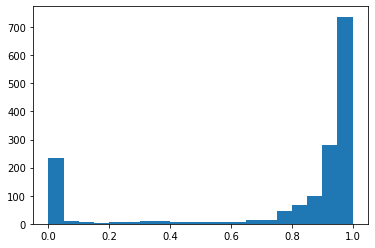

In [531]:
# plot probability distribution predicted by the model:
plt.figure()

plt.hist(lr_probs_test, bins=20)

plt.show()

In [537]:
# print the model coefficients
print('\n'.join([str((x, c)) for (x, c) in zip(X.drop(drop_c, 1).columns, lr_model.named_steps['model'].coef_[0])]))

('age', -11.779131550850984)
('length_of_service', 11.746178898611658)
('city_name', 0.3240058999815704)
('department_name', -1.0667603957087963)
('job_title', 2.450777507831435)
('store_name', 0.7117447463579727)
('gender_short', 0.3239741103666952)


In [564]:
# print auc score for train and test:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(Y, lr_probs))
print(roc_auc_score(y_test, lr_probs_test))

0.9835607464250263
0.9808785471566488


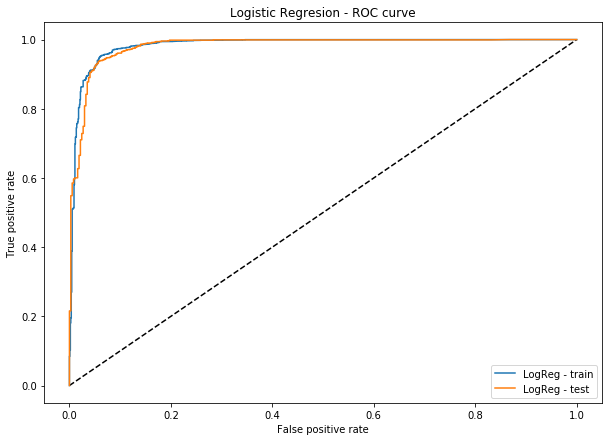

In [569]:
# plot the ROC curve:
from sklearn import metrics
import matplotlib.pyplot as plt

lr_probs = [y for (x, y) in lr_model.predict_proba(X)]
lr_probs_test = [y for (x, y) in lr_model.predict_proba(X_test)]

lr_fpr_train, lr_tpr_train, _ = metrics.roc_curve(Y, lr_probs)
lr_fpr, lr_tpr, _ = metrics.roc_curve(y_test, lr_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr_train, lr_tpr_train, label='LogReg - train')
plt.plot(lr_fpr, lr_tpr, label='LogReg - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic Regresion - ROC curve')
plt.legend(loc='best')
plt.show()

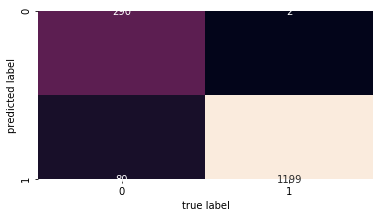

In [539]:
# confusion matrix logistic regression number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, lr_model.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [640]:
# we can save the estimated model as a pickle object;
# this allow us to import later and re-use it only for prediction
with open('lr_model.pkl', 'wb') as f:
    pkl.dump(lr_model, f)

## Decision tree

In [570]:
from sklearn.tree import DecisionTreeClassifier

In [593]:
dt = DecisionTreeClassifier(random_state=r_seed)

In [594]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [595]:
# we can create sequence of number using numpy arange function
np.arange(4, 15, 2) # this is just an example.

array([ 4,  6,  8, 10, 12, 14])

In [596]:
# first analysis: Randomized Search
# the criterion are fixed, but we can change the max_depth and the min_samples_leaf.
params = {'criterion': ['gini', 'entropy'],
          'max_depth': np.arange(4, 15, 2),
          'min_samples_leaf': [1, 0.01, 0.001]}

# parameters tuning:
cv_tuning = RandomizedSearchCV(dt, params, random_state=r_seed, scoring='roc_auc',
                               return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [597]:
print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [598]:
# secong analysis: Randomized Search
# we keep the same criterion. We change the max depth and the min_samples_leaf (we reduce it)
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [3, 4, 5], 
          'min_samples_leaf': [0.1, 0.01, 0.001]}

# parameters tuning, removing n_iter
cv_tuning = RandomizedSearchCV(dt, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [599]:
print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=DecisionTreeClassifier(class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort=False,
                                                    random_state=1123,
                                                    splitter='best')

In [600]:
# Let's do other analysis: 
# We did Randomized Search. Now we do Grid Search. 
# We choose entropy as criterion.
dt = DecisionTreeClassifier(random_state=r_seed, criterion='entropy')
params = {'max_depth': [4, 5], 'min_samples_leaf': [0.05, 0.01]}
cv_tuning = GridSearchCV(dt, params, scoring='roc_auc', return_train_score=True, cv=5)

In [601]:
cv_tuning.fit(X, Y)
print('\n'.join([str((x, y, z)) for (x, y, z) in zip(cv_tuning.cv_results_['params'], cv_tuning.cv_results_['mean_train_score'], cv_tuning.cv_results_['mean_test_score'])]))

({'max_depth': 4, 'min_samples_leaf': 0.05}, 0.9263664506170425, 0.9238384445628687)
({'max_depth': 4, 'min_samples_leaf': 0.01}, 0.9149363479623387, 0.9104099348715048)
({'max_depth': 5, 'min_samples_leaf': 0.05}, 0.9506007607069737, 0.9503932172752045)
({'max_depth': 5, 'min_samples_leaf': 0.01}, 0.958922737818469, 0.9554419121907134)


In [602]:
# Another:
dt = DecisionTreeClassifier(random_state=r_seed, criterion='entropy',
                            max_depth=4, min_samples_leaf=0.01)

dt.fit(X, Y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.01, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=1123, splitter='best')

In [603]:
# Let's compare the results obtained (prediction on train and test):
dt_probs = [y for (x, y) in dt.predict_proba(X)]
dt_probs_test = [y for (x, y) in dt.predict_proba(X_test)]

In [604]:
# auc score for train and test:
print('Train set auc: {}'.format(roc_auc_score(Y, dt_probs))) # train
print('Train set auc: {}'.format(roc_auc_score(y_test, dt_probs_test))) #test

Train set auc: 0.9127402589933814
Train set auc: 0.9158269010059185


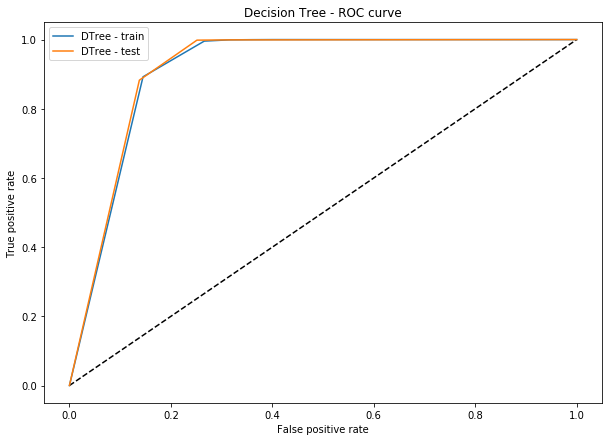

In [605]:
# plot ROC curve:

dt_fpr_train, dt_tpr_train, _ = metrics.roc_curve(Y, dt_probs)
dt_fpr, dt_tpr, _ = metrics.roc_curve(y_test, dt_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(dt_fpr_train, dt_tpr_train, label='DTree - train')
plt.plot(dt_fpr, dt_tpr, label='DTree - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Decision Tree - ROC curve')
plt.legend(loc='best')
plt.show()

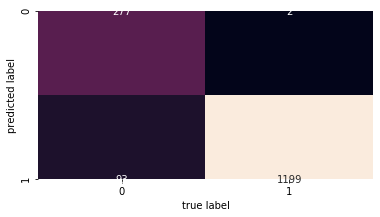

In [606]:
# confusion matrix for decision tree number 1:

from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, dt.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [641]:
with open('dt_model.pkl', 'wb') as f:
    pkl.dump(dt, f)

## Random forest

In [607]:
# this function allows to extract the split of the tree in a readable way
from sklearn.tree import _tree

def tree_to_code(tree, feature_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]
    #print("def tree({}):".format(", ".join(feature_names)))

    def recurse(node, depth):
        indent = "  " * (depth-1)
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            print("{}if {} <= {}:".format(indent, name, threshold))
            recurse(tree_.children_left[node], depth + 1)
            print("{}else:  # if {} > {}".format(indent, name, threshold))
            recurse(tree_.children_right[node], depth + 1)
        else:
            print("{}return {}".format(indent, str(round(tree_.value[node][0][1] / (tree_.value[node][0][0] + tree_.value[node][0][1]) * 100, 2)) + '%'))

    recurse(0, 1)

In [608]:
tree_to_code(dt, X.columns)

if age <= 64.5:
  if store_name <= 0.6560005843639374:
    if city_name <= 0.7773118019104004:
      return 0.0%
    else:  # if city_name > 0.7773118019104004
      return 19.4%
  else:  # if store_name > 0.6560005843639374
    if length_of_service <= 1.5:
      if city_name <= 0.7883607745170593:
        return 0.0%
      else:  # if city_name > 0.7883607745170593
        return 3.85%
    else:  # if length_of_service > 1.5
      if age <= 59.5:
        return 95.23%
      else:  # if age > 59.5
        return 73.52%
else:  # if age > 64.5
  if city_name <= 0.7671458721160889:
    if store_name <= 0.20439254492521286:
      return 2.04%
    else:  # if store_name > 0.20439254492521286
      return 0.0%
  else:  # if city_name > 0.7671458721160889
    return 0.0%


In [609]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50)

In [610]:
np.logspace(-1, -3, 3)

array([0.1  , 0.01 , 0.001])

In [612]:
# First analysis: Randomized Search 
params = {'criterion': ['gini', 'entropy'],
          'max_depth': [2, 3, 4, 5],
          'min_samples_leaf': np.logspace(-1, -3, 3)} #[0.1, 0.01, 0.001]

# parameters tuning:
cv_tuning = RandomizedSearchCV(rf, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [613]:
print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [614]:
# Second analysis: Randomized Search 
# we fix the criterion and we change the max_depth, min_samples_leaf and max_features

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50, criterion='gini')

params = {'max_depth': [2, 3],
          'min_samples_leaf': [0.01, 0.001, 1],
          'max_features': ['sqrt', 0.2, 0.5]}
# parameters tuning:
cv_tuning = RandomizedSearchCV(rf, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [615]:
print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators=50,
                                                    n_jobs=None,
  

In [616]:
# Let's do other analysis: 
# We did Randomized Search. Now we do Grid Search. 
# We choose gini as criterion.

rf = RandomForestClassifier(random_state=r_seed, n_estimators=50, criterion='gini', max_depth=3)

params = {'min_samples_leaf': [0.01, 0.001], # same as before
          'max_features': [0.2, 0.3, 0.4, 0.5]}

# parameters tuning:
cv_tuning = GridSearchCV(rf, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=3,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=50, n_jobs=None,
                                              oob_score=False,
                                              random_state=1123, verbose=0,
                                              warm_start=False),
             iid='warn'

In [617]:
rf = RandomForestClassifier(random_state=r_seed, n_estimators=50,
                            criterion='gini', max_depth=3,
                            min_samples_leaf=0.001, max_features=0.5,
                            warm_start=True)

# now we tune the number of estimator
for i in range(5):
    rf.fit(X, Y)
    probs = [y for (x, y) in rf.predict_proba(X)]
    probs_test = [y for (x, y) in rf.predict_proba(X_test)]
    print(rf.n_estimators, roc_auc_score(Y, probs), roc_auc_score(y_test, probs_test))
    rf.n_estimators += 50

50 0.9153114396661441 0.9255901613520265
100 0.9204478000065011 0.9286956815266556
150 0.9265945795920817 0.9315311564687084
200 0.9263250344432692 0.9325685802371897
250 0.9266912207794806 0.9332459436955691


In [618]:
# we redo the Random Forest Classifier changing the number of estimators. 
# we choose 150 estimators because we have the smallest difference between train and test. 

rf = RandomForestClassifier(random_state=r_seed, n_estimators=150,
                            criterion='gini', max_depth=3,
                            min_samples_leaf=0.001, max_features=0.5,
                            warm_start=True)

rf.fit(X, Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features=0.5, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.001, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=150,
                       n_jobs=None, oob_score=False, random_state=1123,
                       verbose=0, warm_start=True)

In [619]:
# Let's compare the results obtained (prediction on train and test):
rf_probs = [y for (x, y) in rf.predict_proba(X)]
rf_probs_test = [y for (x, y) in rf.predict_proba(X_test)]

# Print auc score:
print(roc_auc_score(Y, rf_probs))
print(roc_auc_score(y_test, rf_probs_test))

0.9265945795920817
0.9315311564687084


In [620]:
# print the coefficients:
feats = [(x, y) for x, y in zip(X.columns, rf.feature_importances_) if y > 0]
sorted(feats, reverse=True, key=lambda x: x[1])

[('age', 0.43596163456165915),
 ('store_name', 0.3025065538431566),
 ('length_of_service', 0.11316419732365661),
 ('city_name', 0.11123364734261197),
 ('job_title', 0.02405999214826246),
 ('department_name', 0.013007473822296979),
 ('gender_short', 6.650095835622588e-05)]

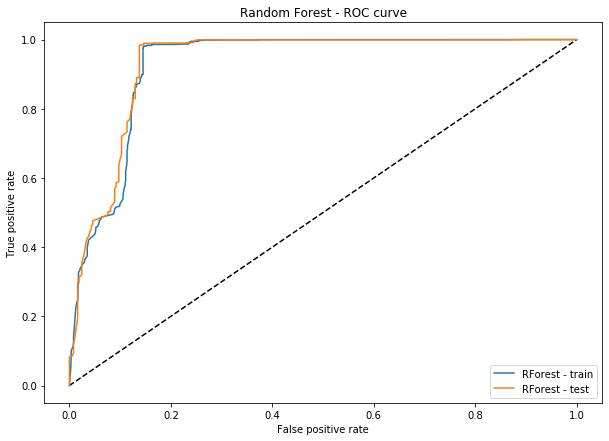

In [622]:
# Plot the ROC curve:
rf_fpr_train, rf_tpr_train, _ = metrics.roc_curve(Y, rf_probs)
rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test, rf_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(rf_fpr_train, rf_tpr_train, label='RForest - train')
plt.plot(rf_fpr, rf_tpr, label='RForest - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Random Forest - ROC curve')
plt.legend(loc='best')
plt.show()

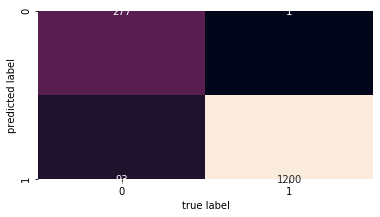

In [644]:
# confusion matrix for random forest number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, rf.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [642]:
with open('rf_model.pkl', 'wb') as f:
    pkl.dump(rf, f)

## Gradient Boosting

In [623]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier(random_state=r_seed, n_estimators=50)

In [624]:
np.logspace(0,-3,3) # initial value of the learning rate

array([1.        , 0.03162278, 0.001     ])

In [625]:
# First analysis Randomized Search:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : np.logspace(0, -3, 4), # initial set for the learning rate
          'subsample' : np.logspace(0, -3, 3),
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

# parameters tuning:
cv_tuning = RandomizedSearchCV(gb,
                               params,
                               random_state=r_seed,
                               n_iter = 20, # how many iterations
                               scoring='roc_auc', 
                               return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

# If the learning rate is too high, the algorithm will never reach the optimum. 
# In contrast, if a value is too small is not efficient. 
# We have to find the parameter that is optimal to have the best estimation of the parameter.
# The other parameter is the cross validation (we have seen it in random forest)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [626]:
print(cv_tuning) 
# the last 2 numbers in the first row are the score in the train set and test set
# 0.5 is random guess. it is a straight line

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [627]:
# Second analysis: let's do another Randomized Search based on a reduced set of parameters
# The first analysis is not good because we have 0.5 as score:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : [0.001,0.0001,0.01], # change this
          'subsample' : np.logspace(0, -3, 3),
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

cv_tuning = RandomizedSearchCV(gb,
                               params,
                               random_state=r_seed,
                               n_iter = 20,
                               scoring='roc_auc', 
                               return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [628]:
print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                        init=None,
                                                        learning_rate=0.1,
                                                        loss='deviance',
                                                        max_depth=3,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                     

In [629]:
# Now, let's do a Grid Search:
params = {'loss' :['deviance', 'exponential'],
          'learning_rate' : [0.001,0.0001,0.01],
          'subsample' : [1,0.9], # change this
          'max_features': ['sqrt','log2', 0.2, 0.5,0.8,1],
          'min_samples_split' : np.logspace(-1, -3, 3),
        }

cv_tuning = GridSearchCV(gb, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=50,
                                                  n_iter_no_...
                                                  validation_fractio

In [630]:
print(cv_tuning) # I found a good set of hyper parameters

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=GradientBoostingClassifier(criterion='friedman_mse',
                                                  init=None, learning_rate=0.1,
                                                  loss='deviance', max_depth=3,
                                                  max_features=None,
                                                  max_leaf_nodes=None,
                                                  min_impurity_decrease=0.0,
                                                  min_impurity_split=None,
                                                  min_samples_leaf=1,
                                                  min_samples_split=2,
                                                  min_weight_fraction_leaf=0.0,
                                                  n_estimators=50,
                                                  n_iter_no_...
                                                  validation_fractio

In [631]:
# this command puts together all the results of the grid search. I ordered by the result on the test set and then I choose the second best one
result_cv = pd.DataFrame([(p,tr,te) for (p,tr,te) in zip(cv_tuning.cv_results_['params'],cv_tuning.cv_results_['mean_train_score'],cv_tuning.cv_results_['mean_test_score']) if te > 0.84]).sort_values(2,ascending=[0])
result_cv

# I choose the second (also the first one was ok). The first 10 models are all very good.

,0,1,2
206,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.939061,0.940226
208,"{'learning_rate': 0.01, 'loss': 'exponential',...",0.937077,0.938359
105,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.937547,0.936452
87,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.937547,0.936452
35,"{'learning_rate': 0.001, 'loss': 'deviance', '...",0.936932,0.936020
...,...,...,...
136,"{'learning_rate': 0.0001, 'loss': 'exponential...",0.906814,0.901815
132,"{'learning_rate': 0.0001, 'loss': 'exponential...",0.905674,0.900677
100,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.905333,0.900211
96,"{'learning_rate': 0.0001, 'loss': 'deviance', ...",0.903106,0.897750


In [632]:
result_cv.reset_index(drop=True,inplace=True)
result_cv.loc[2][0]

{'learning_rate': 0.0001,
 'loss': 'deviance',
 'max_features': 1,
 'min_samples_split': 0.01,
 'subsample': 0.9}

In [633]:
gb_best = GradientBoostingClassifier(learning_rate=0.01,
                                     loss='deviance',
                                     max_features = 0.2,
                                     min_samples_split = 0.01,
                                     subsample = 0.9,
                                     random_state=r_seed,
                                     n_estimators=50)

gb_best.fit(X,Y)

# now we tune the number of estimator
for i in range(10):
    gb_best.fit(X, Y)
    probs = [y for (x, y) in gb_best.predict_proba(X)]
    probs_test = [y for (x, y) in gb_best.predict_proba(X_test)]
    print(gb_best.n_estimators, roc_auc_score(Y, probs), roc_auc_score(y_test, probs_test))
    print(max(probs_test))
    gb_best.n_estimators += 50
    
# the first number is the number of estimators of the gradient boosting
# second and third number are the scores of train set and test set 

# Which number of estimators will I choose? I have to stop when the improvement of the train set is higher
# than the improvement of test set (overfitting)
# We will choose the estimator with the slighest difference between train and test.
# So we will choose around 400.

50 0.925106955415032 0.9321151292841552
0.8174027551067006
100 0.9272008061350276 0.9346996871976055
0.8566930447228931
150 0.9326200888648848 0.9377635753988793
0.883660363085096
200 0.9419739056291929 0.9464747845264082
0.9047516126934881
250 0.9449366518891915 0.9491167270517812
0.9219140972291363
300 0.9477438720985765 0.9513243468280937
0.9343575754600597
350 0.9528115959423203 0.954528883588001
0.9448098167809597
400 0.9547012874656505 0.9563460629655466
0.9520196214172514
450 0.9578673177757274 0.9595584760447374
0.9590947048114504
500 0.9602705953247169 0.9615759389697774
0.9646395078435706


In [634]:
# final configuration of the model
gb_best = GradientBoostingClassifier(learning_rate=0.01,
                                     loss='deviance',
                                     max_features = 0.2,
                                     min_samples_split = 0.01,
                                     subsample = 0.9,
                                     random_state=r_seed,
                                     n_estimators=400)

gb_best.fit(X,Y)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.01, loss='deviance', max_depth=3,
                           max_features=0.2, max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=0.01,
                           min_weight_fraction_leaf=0.0, n_estimators=400,
                           n_iter_no_change=None, presort='auto',
                           random_state=1123, subsample=0.9, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False)

In [635]:
# calculate probability:
gb_probs = [y for (x, y) in gb_best.predict_proba(X)]
gb_probs_test = [y for (x, y) in gb_best.predict_proba(X_test)]

# calculate auc score:
print(roc_auc_score(Y, gb_probs))
print(roc_auc_score(y_test, gb_probs_test))

0.9547012874656505
0.9563460629655466


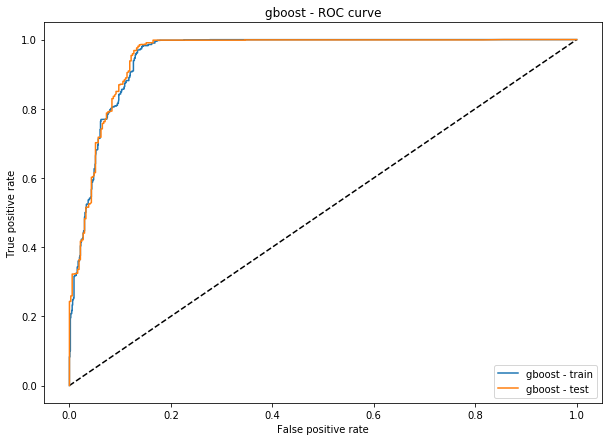

In [637]:
# Plot the ROC curve:
gb_fpr_train, gb_tpr_train, _ = metrics.roc_curve(Y, gb_probs)
gb_fpr, gb_tpr, _ = metrics.roc_curve(y_test, gb_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(gb_fpr_train, gb_tpr_train, label='gboost - train')
plt.plot(gb_fpr, gb_tpr, label='gboost - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('gboost - ROC curve')
plt.legend(loc='best')
plt.show()

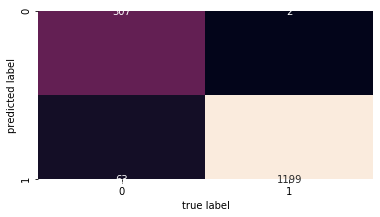

In [638]:
# Confusion matrix for gradient boosting number 1:
from sklearn.metrics import confusion_matrix
import seaborn as sns
mat = confusion_matrix(y_test, gb_best.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [643]:
with open('gb_model.pkl', 'wb') as f:
    pkl.dump(gb_best, f)

## Neural network


In [548]:
import warnings

warnings.filterwarnings('ignore')

In [551]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV


nn = MLPClassifier(random_state=1704, max_iter=50)

In [553]:
# First analysis Randomized Search:
params = {'activation': ['tanh', 'relu'], # choose always these 2 activation functions
          'learning_rate_init': np.logspace(-1, -4, 4),  
          'batch_size': [16, 32, 64]}

cv_tuning = RandomizedSearchCV(nn, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=20)

cv_tuning.fit(X, Y)

print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='relu', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.001,
                                           max_iter=50, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           rando...rue,
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                                      

In [554]:
# Second analysis Randomized Search:
# let's do it again and train the layer size:
# The difference of this model is that I add a multiple fully connected neural
nn = MLPClassifier(random_state=r_seed, activation='tanh', max_iter=50, learning_rate_init=0.0001)

params = {'batch_size': [16, 32, 64], 
          'hidden_layer_sizes': np.arange(20, 101, 20)}

cv_tuning = RandomizedSearchCV(nn, params, random_state=r_seed, scoring='roc_auc', return_train_score=True, cv=5, n_iter=10)

cv_tuning.fit(X, Y)

print(cv_tuning)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=MLPClassifier(activation='tanh', alpha=0.0001,
                                           batch_size='auto', beta_1=0.9,
                                           beta_2=0.999, early_stopping=False,
                                           epsilon=1e-08,
                                           hidden_layer_sizes=(100,),
                                           learning_rate='constant',
                                           learning_rate_init=0.0001,
                                           max_iter=50, momentum=0.9,
                                           n_iter_no_change=10,
                                           nesterovs_momentum=True, power_t=0.5,
                                           random_state=1123, shuffle=True,
                                           solver='adam', tol=0.0001,
                                           validation_fraction=0.1,
                 

In [556]:
# Let's do a Grid Search:
params = {'batch_size': [16, 32], 'hidden_layer_sizes': [100, 120, 150]}

cv_tuning = GridSearchCV(nn, params, scoring='roc_auc', return_train_score=True, cv=5)

cv_tuning.fit(X, Y)

print(cv_tuning)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=MLPClassifier(activation='tanh', alpha=0.0001,
                                     batch_size='auto', beta_1=0.9,
                                     beta_2=0.999, early_stopping=False,
                                     epsilon=1e-08, hidden_layer_sizes=(100,),
                                     learning_rate='constant',
                                     learning_rate_init=0.0001, max_iter=50,
                                     momentum=0.9, n_iter_no_change=10,
                                     nesterovs_momentum=True, power_t=0.5,
                                     random_state=1123, shuffle=True,
                                     solver='adam', tol=0.0001,
                                     validation_fraction=0.1, verbose=False,
                                     warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'batch_size': [16, 32],
                 

In [557]:
nn = MLPClassifier(random_state=r_seed, activation='tanh', max_iter=500,
                   learning_rate_init=0.0001, batch_size=16,
                   hidden_layer_sizes=(120,), verbose=True,
                   n_iter_no_change=100, tol=1e-5)

nn.fit(X, Y)

Iteration 1, loss = 0.55524183
Iteration 2, loss = 0.45542885
Iteration 3, loss = 0.39715236
Iteration 4, loss = 0.36015298
Iteration 5, loss = 0.33348529
Iteration 6, loss = 0.30899767
Iteration 7, loss = 0.28680718
Iteration 8, loss = 0.26400441
Iteration 9, loss = 0.24274342
Iteration 10, loss = 0.22473926
Iteration 11, loss = 0.20785490
Iteration 12, loss = 0.19268150
Iteration 13, loss = 0.17901070
Iteration 14, loss = 0.16740778
Iteration 15, loss = 0.15775117
Iteration 16, loss = 0.14895430
Iteration 17, loss = 0.14191553
Iteration 18, loss = 0.13544569
Iteration 19, loss = 0.12953472
Iteration 20, loss = 0.12427443
Iteration 21, loss = 0.12012859
Iteration 22, loss = 0.11612401
Iteration 23, loss = 0.11232355
Iteration 24, loss = 0.10903952
Iteration 25, loss = 0.10687185
Iteration 26, loss = 0.10416353
Iteration 27, loss = 0.10139050
Iteration 28, loss = 0.09956647
Iteration 29, loss = 0.09777252
Iteration 30, loss = 0.09579302
Iteration 31, loss = 0.09435359
Iteration 32, los

Iteration 253, loss = 0.05664370
Iteration 254, loss = 0.05667146
Iteration 255, loss = 0.05670381
Iteration 256, loss = 0.05626117
Iteration 257, loss = 0.05698899
Iteration 258, loss = 0.05743173
Iteration 259, loss = 0.05702527
Iteration 260, loss = 0.05637327
Iteration 261, loss = 0.05632149
Iteration 262, loss = 0.05698020
Iteration 263, loss = 0.05643947
Iteration 264, loss = 0.05666137
Iteration 265, loss = 0.05679941
Iteration 266, loss = 0.05670526
Iteration 267, loss = 0.05609384
Iteration 268, loss = 0.05700367
Iteration 269, loss = 0.05650061
Iteration 270, loss = 0.05563923
Iteration 271, loss = 0.05659216
Iteration 272, loss = 0.05639915
Iteration 273, loss = 0.05660311
Iteration 274, loss = 0.05613164
Iteration 275, loss = 0.05591753
Iteration 276, loss = 0.05634744
Iteration 277, loss = 0.05580478
Iteration 278, loss = 0.05582549
Iteration 279, loss = 0.05649538
Iteration 280, loss = 0.05547884
Iteration 281, loss = 0.05591797
Iteration 282, loss = 0.05588734
Iteration 

MLPClassifier(activation='tanh', alpha=0.0001, batch_size=16, beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(120,), learning_rate='constant',
              learning_rate_init=0.0001, max_iter=500, momentum=0.9,
              n_iter_no_change=100, nesterovs_momentum=True, power_t=0.5,
              random_state=1123, shuffle=True, solver='adam', tol=1e-05,
              validation_fraction=0.1, verbose=True, warm_start=False)

In [697]:
# Plot the ROC curve:
nn_fpr_train, nn_tpr_train, _ = metrics.roc_curve(Y, nn_probs)
nn_fpr, nn_tpr, _ = metrics.roc_curve(y_test, nn_probs_test)

plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(nn_fpr_train, nn_tpr_train, label='NNetwork - train')
plt.plot(nn_fpr, nn_tpr, label='NNetwork - test')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Neural Network - ROC curve')
plt.legend(loc='best')
plt.show()

ValueError: Found input variables with inconsistent numbers of samples: [4713, 1571]

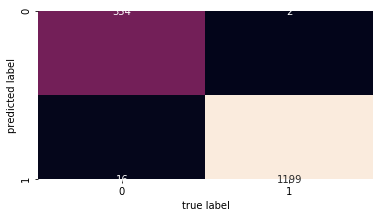

In [559]:
# Confusion matrix for neural network:
mat = confusion_matrix(y_test, nn.predict(X_test))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [645]:
with open('nn_model.pkl', 'wb') as f:
    pkl.dump(nn, f)

# Model comparison

In [646]:
import pickle as pkl
import pandas as pd
from sqlalchemy import create_engine
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [647]:
import warnings
warnings.filterwarnings('ignore')

In [648]:
# define the function to do the confusion matrix we are gonna do later:
def pretty_confusion_matrix(y, preds):
    return pd.DataFrame(confusion_matrix(y, preds),
                        columns=pd.MultiIndex(levels=[['prediction'], ['0', '1']], codes=[[0, 0], [0, 1]]),
                        index=pd.MultiIndex(levels=[['STATUS'], ['0', '1']], codes=[[0, 0], [0, 1]]))

In [649]:
# open all the models that we have saved previously:

with open('lr_model.pkl', 'rb') as f:
    lr = pkl.load(f)

with open('dt_model.pkl', 'rb') as f:
    dt = pkl.load(f)

with open('rf_model.pkl', 'rb') as f:
    rf = pkl.load(f)

with open('gb_model.pkl', 'rb') as f:
    gb = pkl.load(f)

with open('nn_model.pkl', 'rb') as f:
    nn = pkl.load(f)

In [653]:
# open train and test 
train = pd.read_csv('train')
test = pd.read_csv('test')

X = train.drop('STATUS', 1)
Y = train['STATUS']
X_test = test.drop('STATUS', 1)
y_test = test['STATUS']

In [654]:
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve, roc_auc_score

In [655]:
# recall all the models previously done:
lr_preds = lr.predict(X_test)
lr_probs_train = [y for (x, y) in lr.predict_proba(X)]
lr_probs = [y for (x, y) in lr.predict_proba(X_test)]
lr_auc_train = roc_auc_score(Y, lr_probs_train)
lr_auc = roc_auc_score(y_test, lr_probs)

dt_preds = dt.predict(X_test)
dt_probs_train = [y for (x, y) in dt.predict_proba(X)]
dt_probs = [y for (x, y) in dt.predict_proba(X_test)]
dt_auc_train = roc_auc_score(Y, dt_probs_train)
dt_auc = roc_auc_score(y_test, dt_probs)

rf_preds = rf.predict(X_test)
rf_probs_train = [y for (x, y) in rf.predict_proba(X)]
rf_probs = [y for (x, y) in rf.predict_proba(X_test)]
rf_auc_train = roc_auc_score(Y, rf_probs_train)
rf_auc = roc_auc_score(y_test, rf_probs)

gb_preds = gb.predict(X_test)
gb_probs_train = [y for (x, y) in gb.predict_proba(X)]
gb_probs = [y for (x, y) in gb.predict_proba(X_test)]
gb_auc_train = roc_auc_score(Y, gb_probs_train)
gb_auc = roc_auc_score(y_test, gb_probs)

nn_preds = nn.predict(X_test)
nn_probs_train = [y for (x, y) in nn.predict_proba(X)]
nn_probs = [y for (x, y) in nn.predict_proba(X_test)]
nn_auc_train = roc_auc_score(Y, nn_probs_train)
nn_auc = roc_auc_score(y_test, nn_probs)

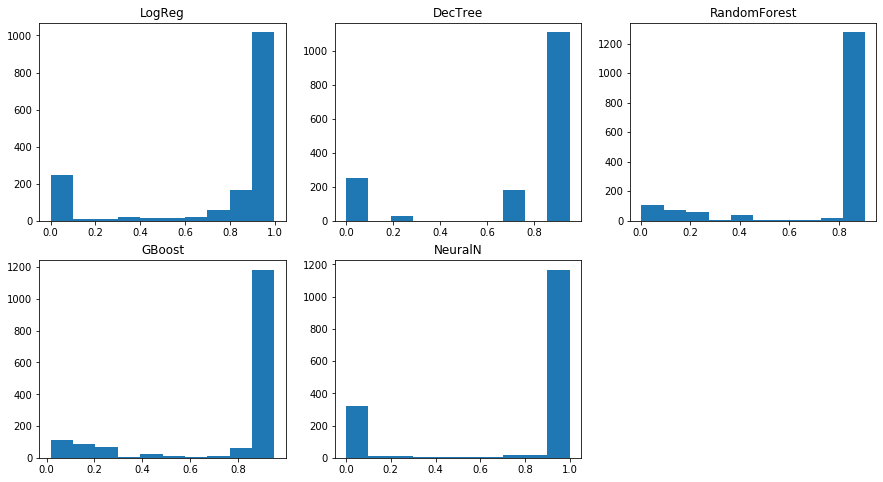

In [656]:
# Plot the probbaility distribution of all the models created:
plt.figure(figsize=(15, 8))
i = 230

for model_name, probs in zip(['LogReg', 'DecTree', 'RandomForest', 'GBoost', 'NeuralN'],
                             [lr_probs, dt_probs, rf_probs, gb_probs, nn_probs]):
    i += 1
    plt.subplot(i)
    plt.hist(probs)
    plt.title(model_name)
    
plt.show()

## ROC AUC curve

In [657]:
# ROC curve for each model:
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_probs)
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
gb_fpr, gb_tpr, _ = roc_curve(y_test, gb_probs)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_probs)

In [658]:
pd.DataFrame({'train_ROC': [lr_auc_train, dt_auc_train, rf_auc_train, gb_auc_train, nn_auc_train],
              'test_ROC': [lr_auc, dt_auc, rf_auc, gb_auc, nn_auc]},
             index=['Logistic Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'Neural Network'])

,train_ROC,test_ROC
Logistic Regression,0.983567,0.980879
Decision Tree,0.912740,0.915827
Random Forest,0.926595,0.931531
Gradient Boosting,0.954701,0.956346
Neural Network,0.997801,0.998371


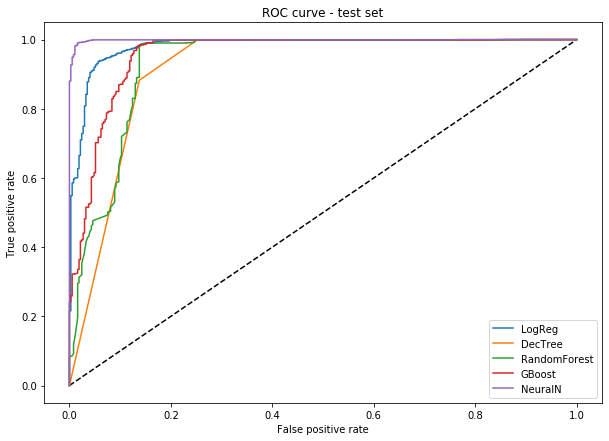

In [659]:
plt.figure(1, figsize=(10, 7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(lr_fpr, lr_tpr, label='LogReg')
plt.plot(dt_fpr, dt_tpr, label='DecTree')
plt.plot(rf_fpr, rf_tpr, label='RandomForest')
plt.plot(gb_fpr, gb_tpr, label='GBoost')
plt.plot(nn_fpr, nn_tpr, label='NeuralN')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve - test set')
plt.legend(loc='best')
plt.show()

We notice that the best model is the Neural Network since its curve contains the biggest AUC

## Results

In [660]:
# Confusion matrix (again):
pd.DataFrame([['TN', 'FP'], ['FN', 'TP']],
             columns=pd.MultiIndex(levels=[['prediction'], ['0', '1']], codes=[[0, 0], [0, 1]]),
             index=pd.MultiIndex(levels=[['STATUS'], ['0', '1']], codes=[[0, 0], [0, 1]]))

prediction    
                  0   1
STATUS 0         TN  FP
       1         FN  TP

In [661]:
# Logistic regression
pretty_confusion_matrix(y_test, lr_preds)

prediction      
                  0     1
STATUS 0        290    80
       1          2  1199

In [662]:
# Decision tree
pretty_confusion_matrix(y_test, dt_preds)

prediction      
                  0     1
STATUS 0        277    93
       1          2  1199

In [663]:
# Random forest
pretty_confusion_matrix(y_test, rf_preds)

prediction      
                  0     1
STATUS 0        277    93
       1          1  1200

In [664]:
# Gradient boosting
pretty_confusion_matrix(y_test, gb_preds)

prediction      
                  0     1
STATUS 0        307    63
       1          2  1199

In [665]:
# Neural network
pretty_confusion_matrix(y_test, nn_preds)

prediction      
                  0     1
STATUS 0        354    16
       1          2  1199

## Accuracy

In [666]:
accuracies = [] # percentage of the correct classified instances
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    a = accuracy_score(y_test, eval(item))
    accuracies.append(a)
    print('accuracy for {}: {}'.format(item,a))
    
# also from here I can see that neural network is the model performing better 

accuracy for lr_preds: 0.9478039465308721
accuracy for dt_preds: 0.939528962444303
accuracy for rf_preds: 0.9401654996817314
accuracy for gb_preds: 0.9586250795671547
accuracy for nn_preds: 0.988542329726289


## Precision

Precision is the percentage of true positive on all records predicted as positive TP/ (TP+FP)
Recall is the percentage of true positive on all observed positive records TP/(TP+FN)

In [667]:
precisions = []
recalls = []
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    p = precision_score(y_test, eval(item))
    r = recall_score(y_test, eval(item))
    precisions.append(p)
    recalls.append(r)
    print('precision for {}: {}'.format(item,p))
    print('recall for {}: {}'.format(item,r))
    print('\n')

precision for lr_preds: 0.9374511336982018
recall for lr_preds: 0.9983347210657785


precision for dt_preds: 0.9280185758513931
recall for dt_preds: 0.9983347210657785


precision for rf_preds: 0.9280742459396751
recall for rf_preds: 0.9991673605328892


precision for gb_preds: 0.9500792393026941
recall for gb_preds: 0.9983347210657785


precision for nn_preds: 0.9868312757201646
recall for nn_preds: 0.9983347210657785




## F-1 score

In [668]:
f1 = []
for item in ['lr_preds','dt_preds','rf_preds','gb_preds','nn_preds']:
    f = f1_score(y_test, eval(item))
    f1.append(f)
    print('f1-score for {}: {}'.format(item,f))

f1-score for lr_preds: 0.9669354838709678
f1-score for dt_preds: 0.9618933012434818
f1-score for rf_preds: 0.9623095429029671
f1-score for gb_preds: 0.9736094194072268
f1-score for nn_preds: 0.9925496688741723


I used the default cut-off of 0.5. The scores above this value will classified as positive, those below as negative.
Having already a very high accuracy with the default cut-off, so it would not be necessary to change it. Because of the high accuracy, we need to choose the best cut-off value. The optimal one is where the “true positive rate” is high and the “false positive rate” is low. The optimal cut-off is the point where there is the elbow of the ROC curve.

In [669]:
# let's find the optimal cut-off: 
# we consider our best model, which is Neural Network
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_test,nn_probs)

In [670]:
# compute the optimal threshold
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_threshold

0.7569963882474845

In [671]:
from sklearn.metrics import make_scorer

In [672]:
# let's set our new cut-off:
cutoff = 0.7698501664999003
def new_f1(y, probs):
    preds = [1 if x >= cutoff else 0 for x in probs]
    return f1_score(y, preds)

# let's find our new f-1 score:
new_f1_scorer = make_scorer(new_f1, greater_is_better=True, needs_proba=True)

In [673]:
from sklearn.model_selection import cross_validate

In [674]:
# cross-validation:
scores_lr = cross_validate(lr, X, Y, scoring=new_f1_scorer, cv=5)

In [675]:
print(scores_lr['test_score'], '--->', np.mean(scores_lr['test_score']))

[0.96296296 0.96575821 0.96089385 0.97214485 0.97083333] ---> 0.9665186417765573


In [676]:
for item in ['lr','dt','rf','gb','nn']:
    scores = cross_validate(eval(item), X, Y, scoring=new_f1_scorer, cv=5)
    print('test --> new f1-score for {}: {}'.format(item,np.mean(scores['test_score'])))

test --> new f1-score for lr: 0.9665186417765573
test --> new f1-score for dt: 0.9282703035560234
test --> new f1-score for rf: 0.9603405032337484
test --> new f1-score for gb: 0.9705849781031093
Iteration 1, loss = 0.57137758
Iteration 2, loss = 0.48207202
Iteration 3, loss = 0.42392566
Iteration 4, loss = 0.38450617
Iteration 5, loss = 0.35797171
Iteration 6, loss = 0.33635049
Iteration 7, loss = 0.31616392
Iteration 8, loss = 0.29855033
Iteration 9, loss = 0.27933814
Iteration 10, loss = 0.26021616
Iteration 11, loss = 0.24456201
Iteration 12, loss = 0.22994953
Iteration 13, loss = 0.21516059
Iteration 14, loss = 0.20201400
Iteration 15, loss = 0.19049838
Iteration 16, loss = 0.17875480
Iteration 17, loss = 0.16989421
Iteration 18, loss = 0.16185131
Iteration 19, loss = 0.15454417
Iteration 20, loss = 0.14840794
Iteration 21, loss = 0.14268584
Iteration 22, loss = 0.13698216
Iteration 23, loss = 0.13206416
Iteration 24, loss = 0.12714508
Iteration 25, loss = 0.12401788
Iteration 26,

Iteration 249, loss = 0.05995613
Iteration 250, loss = 0.05825691
Iteration 251, loss = 0.05876519
Iteration 252, loss = 0.05881628
Iteration 253, loss = 0.05869319
Iteration 254, loss = 0.05959087
Iteration 255, loss = 0.05843613
Iteration 256, loss = 0.05906029
Iteration 257, loss = 0.05846641
Iteration 258, loss = 0.05819142
Iteration 259, loss = 0.05846166
Iteration 260, loss = 0.05776512
Iteration 261, loss = 0.05854937
Iteration 262, loss = 0.05872088
Iteration 263, loss = 0.05785576
Iteration 264, loss = 0.05813534
Iteration 265, loss = 0.05878533
Iteration 266, loss = 0.05809954
Iteration 267, loss = 0.05862840
Iteration 268, loss = 0.05858441
Iteration 269, loss = 0.05793984
Iteration 270, loss = 0.05788416
Iteration 271, loss = 0.05786638
Iteration 272, loss = 0.05786089
Iteration 273, loss = 0.05767270
Iteration 274, loss = 0.05806695
Iteration 275, loss = 0.05697284
Iteration 276, loss = 0.05686628
Iteration 277, loss = 0.05767554
Iteration 278, loss = 0.05756567
Iteration 

Iteration 498, loss = 0.05179132
Iteration 499, loss = 0.05204182
Iteration 500, loss = 0.05186819
Iteration 1, loss = 0.57050037
Iteration 2, loss = 0.48398986
Iteration 3, loss = 0.42767403
Iteration 4, loss = 0.38759375
Iteration 5, loss = 0.36041704
Iteration 6, loss = 0.33934435
Iteration 7, loss = 0.32066900
Iteration 8, loss = 0.30254259
Iteration 9, loss = 0.28691687
Iteration 10, loss = 0.26846731
Iteration 11, loss = 0.25096159
Iteration 12, loss = 0.23662543
Iteration 13, loss = 0.22249585
Iteration 14, loss = 0.20968895
Iteration 15, loss = 0.19887753
Iteration 16, loss = 0.18741162
Iteration 17, loss = 0.17688899
Iteration 18, loss = 0.16830038
Iteration 19, loss = 0.16071626
Iteration 20, loss = 0.15381056
Iteration 21, loss = 0.14824549
Iteration 22, loss = 0.14243440
Iteration 23, loss = 0.13794886
Iteration 24, loss = 0.13296456
Iteration 25, loss = 0.12923358
Iteration 26, loss = 0.12529984
Iteration 27, loss = 0.12212351
Iteration 28, loss = 0.11880264
Iteration 29, 

Iteration 250, loss = 0.06174041
Iteration 251, loss = 0.06252371
Iteration 252, loss = 0.06138102
Iteration 253, loss = 0.06193169
Iteration 254, loss = 0.06217817
Iteration 255, loss = 0.06141010
Iteration 256, loss = 0.06164576
Iteration 257, loss = 0.06150118
Iteration 258, loss = 0.06170048
Iteration 259, loss = 0.06145616
Iteration 260, loss = 0.06117032
Iteration 261, loss = 0.06129367
Iteration 262, loss = 0.06132517
Iteration 263, loss = 0.06090997
Iteration 264, loss = 0.06126419
Iteration 265, loss = 0.06213389
Iteration 266, loss = 0.06148508
Iteration 267, loss = 0.06141506
Iteration 268, loss = 0.06115565
Iteration 269, loss = 0.06104048
Iteration 270, loss = 0.06067878
Iteration 271, loss = 0.06118512
Iteration 272, loss = 0.06143880
Iteration 273, loss = 0.06088863
Iteration 274, loss = 0.06076918
Iteration 275, loss = 0.06061695
Iteration 276, loss = 0.06013454
Iteration 277, loss = 0.06099401
Iteration 278, loss = 0.06039826
Iteration 279, loss = 0.06081694
Iteration 

Iteration 500, loss = 0.05375598
Iteration 1, loss = 0.56849799
Iteration 2, loss = 0.47981257
Iteration 3, loss = 0.42452060
Iteration 4, loss = 0.38414237
Iteration 5, loss = 0.35685916
Iteration 6, loss = 0.33620688
Iteration 7, loss = 0.31587391
Iteration 8, loss = 0.29607006
Iteration 9, loss = 0.27681604
Iteration 10, loss = 0.25872005
Iteration 11, loss = 0.24057989
Iteration 12, loss = 0.22465039
Iteration 13, loss = 0.21012191
Iteration 14, loss = 0.19640776
Iteration 15, loss = 0.18547297
Iteration 16, loss = 0.17525369
Iteration 17, loss = 0.16586117
Iteration 18, loss = 0.15760982
Iteration 19, loss = 0.15069882
Iteration 20, loss = 0.14414502
Iteration 21, loss = 0.13836244
Iteration 22, loss = 0.13239317
Iteration 23, loss = 0.12779704
Iteration 24, loss = 0.12293795
Iteration 25, loss = 0.11956874
Iteration 26, loss = 0.11570595
Iteration 27, loss = 0.11250452
Iteration 28, loss = 0.10913928
Iteration 29, loss = 0.10683408
Iteration 30, loss = 0.10454488
Iteration 31, lo

Iteration 252, loss = 0.05212877
Iteration 253, loss = 0.05291994
Iteration 254, loss = 0.05235332
Iteration 255, loss = 0.05346490
Iteration 256, loss = 0.05241380
Iteration 257, loss = 0.05158907
Iteration 258, loss = 0.05316430
Iteration 259, loss = 0.05184560
Iteration 260, loss = 0.05229376
Iteration 261, loss = 0.05257627
Iteration 262, loss = 0.05201098
Iteration 263, loss = 0.05207505
Iteration 264, loss = 0.05239858
Iteration 265, loss = 0.05315845
Iteration 266, loss = 0.05295321
Iteration 267, loss = 0.05185899
Iteration 268, loss = 0.05179107
Iteration 269, loss = 0.05235073
Iteration 270, loss = 0.05117308
Iteration 271, loss = 0.05213565
Iteration 272, loss = 0.05199967
Iteration 273, loss = 0.05181454
Iteration 274, loss = 0.05124981
Iteration 275, loss = 0.05117817
Iteration 276, loss = 0.05176015
Iteration 277, loss = 0.05225814
Iteration 278, loss = 0.05106173
Iteration 279, loss = 0.05144972
Iteration 280, loss = 0.05157413
Iteration 281, loss = 0.05165379
Iteration 

Iteration 1, loss = 0.57063762
Iteration 2, loss = 0.48180230
Iteration 3, loss = 0.42387406
Iteration 4, loss = 0.38535628
Iteration 5, loss = 0.35983818
Iteration 6, loss = 0.33769797
Iteration 7, loss = 0.31664052
Iteration 8, loss = 0.29938841
Iteration 9, loss = 0.27879288
Iteration 10, loss = 0.25885082
Iteration 11, loss = 0.24150009
Iteration 12, loss = 0.22589068
Iteration 13, loss = 0.21148989
Iteration 14, loss = 0.19777987
Iteration 15, loss = 0.18575434
Iteration 16, loss = 0.17483395
Iteration 17, loss = 0.16587563
Iteration 18, loss = 0.15740113
Iteration 19, loss = 0.15014397
Iteration 20, loss = 0.14383944
Iteration 21, loss = 0.13857803
Iteration 22, loss = 0.13316847
Iteration 23, loss = 0.12866301
Iteration 24, loss = 0.12516193
Iteration 25, loss = 0.12060854
Iteration 26, loss = 0.11747988
Iteration 27, loss = 0.11422244
Iteration 28, loss = 0.11165419
Iteration 29, loss = 0.10892747
Iteration 30, loss = 0.10675635
Iteration 31, loss = 0.10459983
Iteration 32, los

Iteration 253, loss = 0.06137258
Iteration 254, loss = 0.06108764
Iteration 255, loss = 0.06137076
Iteration 256, loss = 0.06146447
Iteration 257, loss = 0.06066590
Iteration 258, loss = 0.06154811
Iteration 259, loss = 0.06127432
Iteration 260, loss = 0.06155599
Iteration 261, loss = 0.06041941
Iteration 262, loss = 0.06076266
Iteration 263, loss = 0.06084069
Iteration 264, loss = 0.06128844
Iteration 265, loss = 0.06111695
Iteration 266, loss = 0.06214088
Iteration 267, loss = 0.06142997
Iteration 268, loss = 0.06044427
Iteration 269, loss = 0.06209489
Iteration 270, loss = 0.06057003
Iteration 271, loss = 0.06093963
Iteration 272, loss = 0.06019029
Iteration 273, loss = 0.06074753
Iteration 274, loss = 0.06058653
Iteration 275, loss = 0.06049107
Iteration 276, loss = 0.06007032
Iteration 277, loss = 0.06034429
Iteration 278, loss = 0.06028547
Iteration 279, loss = 0.06046843
Iteration 280, loss = 0.06062670
Iteration 281, loss = 0.06035274
Iteration 282, loss = 0.06017435
Iteration 

Iteration 2, loss = 0.48142555
Iteration 3, loss = 0.42297824
Iteration 4, loss = 0.38502924
Iteration 5, loss = 0.35897286
Iteration 6, loss = 0.33722675
Iteration 7, loss = 0.31693838
Iteration 8, loss = 0.29951530
Iteration 9, loss = 0.28194100
Iteration 10, loss = 0.26239779
Iteration 11, loss = 0.24436488
Iteration 12, loss = 0.23068992
Iteration 13, loss = 0.21657845
Iteration 14, loss = 0.20406879
Iteration 15, loss = 0.19134048
Iteration 16, loss = 0.18052887
Iteration 17, loss = 0.17088741
Iteration 18, loss = 0.16211482
Iteration 19, loss = 0.15398432
Iteration 20, loss = 0.14703124
Iteration 21, loss = 0.14118509
Iteration 22, loss = 0.13571337
Iteration 23, loss = 0.13135916
Iteration 24, loss = 0.12695231
Iteration 25, loss = 0.12292969
Iteration 26, loss = 0.11979595
Iteration 27, loss = 0.11592071
Iteration 28, loss = 0.11383750
Iteration 29, loss = 0.11102524
Iteration 30, loss = 0.10799714
Iteration 31, loss = 0.10666214
Iteration 32, loss = 0.10361708
Iteration 33, lo

Iteration 254, loss = 0.05959090
Iteration 255, loss = 0.05931875
Iteration 256, loss = 0.05996815
Iteration 257, loss = 0.05968076
Iteration 258, loss = 0.06002688
Iteration 259, loss = 0.05966397
Iteration 260, loss = 0.05941425
Iteration 261, loss = 0.05965715
Iteration 262, loss = 0.05962038
Iteration 263, loss = 0.05889236
Iteration 264, loss = 0.05997381
Iteration 265, loss = 0.05996507
Iteration 266, loss = 0.06030646
Iteration 267, loss = 0.05938017
Iteration 268, loss = 0.05927410
Iteration 269, loss = 0.06104068
Iteration 270, loss = 0.05859835
Iteration 271, loss = 0.05903935
Iteration 272, loss = 0.05885430
Iteration 273, loss = 0.05898455
Iteration 274, loss = 0.05875205
Iteration 275, loss = 0.05840331
Iteration 276, loss = 0.05851694
Iteration 277, loss = 0.05945758
Iteration 278, loss = 0.05841196
Iteration 279, loss = 0.05914000
Iteration 280, loss = 0.05900552
Iteration 281, loss = 0.05901602
Iteration 282, loss = 0.05810977
Iteration 283, loss = 0.05835760
Iteration 

In [677]:
# now that we have a new cut-off, we calculate the new probability predictions:
the_cutoff = 0.7698501664999003
new_lr_preds = [1 if x >= the_cutoff else 0 for x in lr_probs]
new_dt_preds = [1 if x >= the_cutoff else 0 for x in dt_probs]
new_rf_preds = [1 if x >= the_cutoff else 0 for x in rf_probs]
new_gb_preds = [1 if x >= the_cutoff else 0 for x in gb_probs]
new_nn_preds = [1 if x >= the_cutoff else 0 for x in nn_probs]

In [678]:
# Now let's do the confusion matrix for each models with the new prediction:
# Logistic regression confusion matrix:
pretty_confusion_matrix(y_test, new_lr_preds)

prediction      
                  0     1
STATUS 0        325    45
       1         33  1168

In [679]:
# Decision tree confusion matrix:
pretty_confusion_matrix(y_test, new_dt_preds)

prediction      
                  0     1
STATUS 0        319    51
       1        141  1060

In [680]:
# Random forest confusion matrix:
pretty_confusion_matrix(y_test, new_rf_preds)

prediction      
                  0     1
STATUS 0        279    91
       1          3  1198

In [681]:
# Gradient boosting confusion matrix:
pretty_confusion_matrix(y_test, new_gb_preds)

prediction      
                  0     1
STATUS 0        314    56
       1         13  1188

In [682]:
# Neural network confusion matrix:
pretty_confusion_matrix(y_test, new_nn_preds)

prediction      
                  0     1
STATUS 0        364     6
       1         18  1183

In [683]:
# Now let's find all the scores for each model with the new prediction:
# Logistic regression scores:
pd.DataFrame([accuracy_score(y_test, new_lr_preds), precision_score(y_test, new_lr_preds), recall_score(y_test, new_lr_preds),
              f1_score(y_test, new_lr_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.950350
Precision,0.962902
Recall,0.972523
F1-Score,0.967688


In [684]:
# Decision tree scores:
pd.DataFrame([accuracy_score(y_test, new_dt_preds), precision_score(y_test, new_dt_preds), recall_score(y_test, new_dt_preds),
              f1_score(y_test, new_dt_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.877785
Precision,0.954095
Recall,0.882598
F1-Score,0.916955


In [685]:
# Random forest scores:
pd.DataFrame([accuracy_score(y_test, new_rf_preds), precision_score(y_test, new_rf_preds), recall_score(y_test, new_rf_preds),
              f1_score(y_test, new_rf_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.940165
Precision,0.929403
Recall,0.997502
F1-Score,0.962249


In [686]:
# Gradient boosting scores:
pd.DataFrame([accuracy_score(y_test, new_gb_preds), precision_score(y_test, new_gb_preds), recall_score(y_test, new_gb_preds),
              f1_score(y_test, new_gb_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.956079
Precision,0.954984
Recall,0.989176
F1-Score,0.971779


In [687]:
# Neural network scores:
pd.DataFrame([accuracy_score(y_test, new_nn_preds), precision_score(y_test, new_nn_preds), recall_score(y_test, new_nn_preds),
              f1_score(y_test, new_nn_preds)],
             index=['Accuracy', 'Precision', 'Recall', 'F1-Score'], columns=['score'])

,score
Accuracy,0.984723
Precision,0.994954
Recall,0.985012
F1-Score,0.989958


## Ensembling models


This is a process that uses different algorithms to create a model in order to gain a better prediction of the outcome, compared to the prediction of a simple stand-alone algorithm. It could also be done by using different training data sets.
The ensemble model then aggregates the prediction of each base model and results in one final prediction for the unseen data.
The goal is to reduce the error of the prediction.
In this case I performed an ensembled model with the algorithms used before. All the models except Decision tree, because it has the smallest accuracy.

In [688]:
# put together the models and it will return probability distribution
from sklearn.ensemble import VotingClassifier

In [689]:
ensemble = VotingClassifier(estimators=[('lr',lr),('rf', rf), ('gnb', gb),('nn',nn)], voting='soft')
# soft instead of using labels use probability.

In [690]:
scores = cross_validate(ensemble, X, Y, scoring=new_f1_scorer, cv=5)
print('test --> new f1-score for ensemble: {}'.format(np.mean(scores['test_score'])))

Iteration 1, loss = 0.57137758
Iteration 2, loss = 0.48207202
Iteration 3, loss = 0.42392566
Iteration 4, loss = 0.38450617
Iteration 5, loss = 0.35797171
Iteration 6, loss = 0.33635049
Iteration 7, loss = 0.31616392
Iteration 8, loss = 0.29855033
Iteration 9, loss = 0.27933814
Iteration 10, loss = 0.26021616
Iteration 11, loss = 0.24456201
Iteration 12, loss = 0.22994953
Iteration 13, loss = 0.21516059
Iteration 14, loss = 0.20201400
Iteration 15, loss = 0.19049838
Iteration 16, loss = 0.17875480
Iteration 17, loss = 0.16989421
Iteration 18, loss = 0.16185131
Iteration 19, loss = 0.15454417
Iteration 20, loss = 0.14840794
Iteration 21, loss = 0.14268584
Iteration 22, loss = 0.13698216
Iteration 23, loss = 0.13206416
Iteration 24, loss = 0.12714508
Iteration 25, loss = 0.12401788
Iteration 26, loss = 0.12023212
Iteration 27, loss = 0.11708273
Iteration 28, loss = 0.11454642
Iteration 29, loss = 0.11123391
Iteration 30, loss = 0.10979203
Iteration 31, loss = 0.10680767
Iteration 32, los

Iteration 255, loss = 0.05843613
Iteration 256, loss = 0.05906029
Iteration 257, loss = 0.05846641
Iteration 258, loss = 0.05819142
Iteration 259, loss = 0.05846166
Iteration 260, loss = 0.05776512
Iteration 261, loss = 0.05854937
Iteration 262, loss = 0.05872088
Iteration 263, loss = 0.05785576
Iteration 264, loss = 0.05813534
Iteration 265, loss = 0.05878533
Iteration 266, loss = 0.05809954
Iteration 267, loss = 0.05862840
Iteration 268, loss = 0.05858441
Iteration 269, loss = 0.05793984
Iteration 270, loss = 0.05788416
Iteration 271, loss = 0.05786638
Iteration 272, loss = 0.05786089
Iteration 273, loss = 0.05767270
Iteration 274, loss = 0.05806695
Iteration 275, loss = 0.05697284
Iteration 276, loss = 0.05686628
Iteration 277, loss = 0.05767554
Iteration 278, loss = 0.05756567
Iteration 279, loss = 0.05807426
Iteration 280, loss = 0.05828943
Iteration 281, loss = 0.05756651
Iteration 282, loss = 0.05724854
Iteration 283, loss = 0.05849917
Iteration 284, loss = 0.05697594
Iteration 

Iteration 4, loss = 0.38759375
Iteration 5, loss = 0.36041704
Iteration 6, loss = 0.33934435
Iteration 7, loss = 0.32066900
Iteration 8, loss = 0.30254259
Iteration 9, loss = 0.28691687
Iteration 10, loss = 0.26846731
Iteration 11, loss = 0.25096159
Iteration 12, loss = 0.23662543
Iteration 13, loss = 0.22249585
Iteration 14, loss = 0.20968895
Iteration 15, loss = 0.19887753
Iteration 16, loss = 0.18741162
Iteration 17, loss = 0.17688899
Iteration 18, loss = 0.16830038
Iteration 19, loss = 0.16071626
Iteration 20, loss = 0.15381056
Iteration 21, loss = 0.14824549
Iteration 22, loss = 0.14243440
Iteration 23, loss = 0.13794886
Iteration 24, loss = 0.13296456
Iteration 25, loss = 0.12923358
Iteration 26, loss = 0.12529984
Iteration 27, loss = 0.12212351
Iteration 28, loss = 0.11880264
Iteration 29, loss = 0.11603680
Iteration 30, loss = 0.11425495
Iteration 31, loss = 0.11095537
Iteration 32, loss = 0.10900373
Iteration 33, loss = 0.10646244
Iteration 34, loss = 0.10496767
Iteration 35, 

Iteration 256, loss = 0.06164576
Iteration 257, loss = 0.06150118
Iteration 258, loss = 0.06170048
Iteration 259, loss = 0.06145616
Iteration 260, loss = 0.06117032
Iteration 261, loss = 0.06129367
Iteration 262, loss = 0.06132517
Iteration 263, loss = 0.06090997
Iteration 264, loss = 0.06126419
Iteration 265, loss = 0.06213389
Iteration 266, loss = 0.06148508
Iteration 267, loss = 0.06141506
Iteration 268, loss = 0.06115565
Iteration 269, loss = 0.06104048
Iteration 270, loss = 0.06067878
Iteration 271, loss = 0.06118512
Iteration 272, loss = 0.06143880
Iteration 273, loss = 0.06088863
Iteration 274, loss = 0.06076918
Iteration 275, loss = 0.06061695
Iteration 276, loss = 0.06013454
Iteration 277, loss = 0.06099401
Iteration 278, loss = 0.06039826
Iteration 279, loss = 0.06081694
Iteration 280, loss = 0.06136018
Iteration 281, loss = 0.06074530
Iteration 282, loss = 0.05962166
Iteration 283, loss = 0.06155325
Iteration 284, loss = 0.06021131
Iteration 285, loss = 0.06045584
Iteration 

Iteration 7, loss = 0.31587391
Iteration 8, loss = 0.29607006
Iteration 9, loss = 0.27681604
Iteration 10, loss = 0.25872005
Iteration 11, loss = 0.24057989
Iteration 12, loss = 0.22465039
Iteration 13, loss = 0.21012191
Iteration 14, loss = 0.19640776
Iteration 15, loss = 0.18547297
Iteration 16, loss = 0.17525369
Iteration 17, loss = 0.16586117
Iteration 18, loss = 0.15760982
Iteration 19, loss = 0.15069882
Iteration 20, loss = 0.14414502
Iteration 21, loss = 0.13836244
Iteration 22, loss = 0.13239317
Iteration 23, loss = 0.12779704
Iteration 24, loss = 0.12293795
Iteration 25, loss = 0.11956874
Iteration 26, loss = 0.11570595
Iteration 27, loss = 0.11250452
Iteration 28, loss = 0.10913928
Iteration 29, loss = 0.10683408
Iteration 30, loss = 0.10454488
Iteration 31, loss = 0.10137163
Iteration 32, loss = 0.09977104
Iteration 33, loss = 0.09759264
Iteration 34, loss = 0.09562044
Iteration 35, loss = 0.09426385
Iteration 36, loss = 0.09274534
Iteration 37, loss = 0.09104857
Iteration 3

Iteration 261, loss = 0.05257627
Iteration 262, loss = 0.05201098
Iteration 263, loss = 0.05207505
Iteration 264, loss = 0.05239858
Iteration 265, loss = 0.05315845
Iteration 266, loss = 0.05295321
Iteration 267, loss = 0.05185899
Iteration 268, loss = 0.05179107
Iteration 269, loss = 0.05235073
Iteration 270, loss = 0.05117308
Iteration 271, loss = 0.05213565
Iteration 272, loss = 0.05199967
Iteration 273, loss = 0.05181454
Iteration 274, loss = 0.05124981
Iteration 275, loss = 0.05117817
Iteration 276, loss = 0.05176015
Iteration 277, loss = 0.05225814
Iteration 278, loss = 0.05106173
Iteration 279, loss = 0.05144972
Iteration 280, loss = 0.05157413
Iteration 281, loss = 0.05165379
Iteration 282, loss = 0.05149895
Iteration 283, loss = 0.05147614
Iteration 284, loss = 0.05132171
Iteration 285, loss = 0.05071325
Iteration 286, loss = 0.05122225
Iteration 287, loss = 0.05077338
Iteration 288, loss = 0.05079960
Iteration 289, loss = 0.05168304
Iteration 290, loss = 0.05166404
Iteration 

Iteration 10, loss = 0.25885082
Iteration 11, loss = 0.24150009
Iteration 12, loss = 0.22589068
Iteration 13, loss = 0.21148989
Iteration 14, loss = 0.19777987
Iteration 15, loss = 0.18575434
Iteration 16, loss = 0.17483395
Iteration 17, loss = 0.16587563
Iteration 18, loss = 0.15740113
Iteration 19, loss = 0.15014397
Iteration 20, loss = 0.14383944
Iteration 21, loss = 0.13857803
Iteration 22, loss = 0.13316847
Iteration 23, loss = 0.12866301
Iteration 24, loss = 0.12516193
Iteration 25, loss = 0.12060854
Iteration 26, loss = 0.11747988
Iteration 27, loss = 0.11422244
Iteration 28, loss = 0.11165419
Iteration 29, loss = 0.10892747
Iteration 30, loss = 0.10675635
Iteration 31, loss = 0.10459983
Iteration 32, loss = 0.10230142
Iteration 33, loss = 0.10029737
Iteration 34, loss = 0.09924180
Iteration 35, loss = 0.09758219
Iteration 36, loss = 0.09568556
Iteration 37, loss = 0.09434254
Iteration 38, loss = 0.09387623
Iteration 39, loss = 0.09319186
Iteration 40, loss = 0.09141714
Iteratio

Iteration 262, loss = 0.06076266
Iteration 263, loss = 0.06084069
Iteration 264, loss = 0.06128844
Iteration 265, loss = 0.06111695
Iteration 266, loss = 0.06214088
Iteration 267, loss = 0.06142997
Iteration 268, loss = 0.06044427
Iteration 269, loss = 0.06209489
Iteration 270, loss = 0.06057003
Iteration 271, loss = 0.06093963
Iteration 272, loss = 0.06019029
Iteration 273, loss = 0.06074753
Iteration 274, loss = 0.06058653
Iteration 275, loss = 0.06049107
Iteration 276, loss = 0.06007032
Iteration 277, loss = 0.06034429
Iteration 278, loss = 0.06028547
Iteration 279, loss = 0.06046843
Iteration 280, loss = 0.06062670
Iteration 281, loss = 0.06035274
Iteration 282, loss = 0.06017435
Iteration 283, loss = 0.06066233
Iteration 284, loss = 0.05971347
Iteration 285, loss = 0.05926421
Iteration 286, loss = 0.05951793
Iteration 287, loss = 0.06027717
Iteration 288, loss = 0.06042409
Iteration 289, loss = 0.06023204
Iteration 290, loss = 0.05948586
Iteration 291, loss = 0.06010503
Iteration 

Iteration 13, loss = 0.21657845
Iteration 14, loss = 0.20406879
Iteration 15, loss = 0.19134048
Iteration 16, loss = 0.18052887
Iteration 17, loss = 0.17088741
Iteration 18, loss = 0.16211482
Iteration 19, loss = 0.15398432
Iteration 20, loss = 0.14703124
Iteration 21, loss = 0.14118509
Iteration 22, loss = 0.13571337
Iteration 23, loss = 0.13135916
Iteration 24, loss = 0.12695231
Iteration 25, loss = 0.12292969
Iteration 26, loss = 0.11979595
Iteration 27, loss = 0.11592071
Iteration 28, loss = 0.11383750
Iteration 29, loss = 0.11102524
Iteration 30, loss = 0.10799714
Iteration 31, loss = 0.10666214
Iteration 32, loss = 0.10361708
Iteration 33, loss = 0.10170676
Iteration 34, loss = 0.09991630
Iteration 35, loss = 0.09871796
Iteration 36, loss = 0.09671822
Iteration 37, loss = 0.09575004
Iteration 38, loss = 0.09379614
Iteration 39, loss = 0.09425397
Iteration 40, loss = 0.09167536
Iteration 41, loss = 0.09125110
Iteration 42, loss = 0.09001421
Iteration 43, loss = 0.08932963
Iteratio

Iteration 265, loss = 0.05996507
Iteration 266, loss = 0.06030646
Iteration 267, loss = 0.05938017
Iteration 268, loss = 0.05927410
Iteration 269, loss = 0.06104068
Iteration 270, loss = 0.05859835
Iteration 271, loss = 0.05903935
Iteration 272, loss = 0.05885430
Iteration 273, loss = 0.05898455
Iteration 274, loss = 0.05875205
Iteration 275, loss = 0.05840331
Iteration 276, loss = 0.05851694
Iteration 277, loss = 0.05945758
Iteration 278, loss = 0.05841196
Iteration 279, loss = 0.05914000
Iteration 280, loss = 0.05900552
Iteration 281, loss = 0.05901602
Iteration 282, loss = 0.05810977
Iteration 283, loss = 0.05835760
Iteration 284, loss = 0.05820290
Iteration 285, loss = 0.05954300
Iteration 286, loss = 0.05783784
Iteration 287, loss = 0.05870518
Iteration 288, loss = 0.05891188
Iteration 289, loss = 0.05850803
Iteration 290, loss = 0.05863366
Iteration 291, loss = 0.05763615
Iteration 292, loss = 0.05868038
Iteration 293, loss = 0.05814774
Iteration 294, loss = 0.05851006
Iteration 

In [691]:
ensemble.fit(X,Y)

Iteration 1, loss = 0.55524614
Iteration 2, loss = 0.45538154
Iteration 3, loss = 0.39691411
Iteration 4, loss = 0.35974920
Iteration 5, loss = 0.33293344
Iteration 6, loss = 0.30826742
Iteration 7, loss = 0.28589373
Iteration 8, loss = 0.26284845
Iteration 9, loss = 0.24140302
Iteration 10, loss = 0.22329239
Iteration 11, loss = 0.20634028
Iteration 12, loss = 0.19111382
Iteration 13, loss = 0.17745869
Iteration 14, loss = 0.16588972
Iteration 15, loss = 0.15629715
Iteration 16, loss = 0.14756659
Iteration 17, loss = 0.14064141
Iteration 18, loss = 0.13421023
Iteration 19, loss = 0.12845942
Iteration 20, loss = 0.12328100
Iteration 21, loss = 0.11918748
Iteration 22, loss = 0.11526951
Iteration 23, loss = 0.11157851
Iteration 24, loss = 0.10834803
Iteration 25, loss = 0.10615410
Iteration 26, loss = 0.10356783
Iteration 27, loss = 0.10087128
Iteration 28, loss = 0.09905099
Iteration 29, loss = 0.09729096
Iteration 30, loss = 0.09539739
Iteration 31, loss = 0.09396060
Iteration 32, los

Iteration 253, loss = 0.05648781
Iteration 254, loss = 0.05658147
Iteration 255, loss = 0.05657185
Iteration 256, loss = 0.05614991
Iteration 257, loss = 0.05689267
Iteration 258, loss = 0.05736904
Iteration 259, loss = 0.05692999
Iteration 260, loss = 0.05630025
Iteration 261, loss = 0.05619594
Iteration 262, loss = 0.05682701
Iteration 263, loss = 0.05633901
Iteration 264, loss = 0.05657135
Iteration 265, loss = 0.05667549
Iteration 266, loss = 0.05659048
Iteration 267, loss = 0.05596848
Iteration 268, loss = 0.05691369
Iteration 269, loss = 0.05638544
Iteration 270, loss = 0.05551524
Iteration 271, loss = 0.05648664
Iteration 272, loss = 0.05628863
Iteration 273, loss = 0.05646423
Iteration 274, loss = 0.05598675
Iteration 275, loss = 0.05580772
Iteration 276, loss = 0.05622048
Iteration 277, loss = 0.05566397
Iteration 278, loss = 0.05574997
Iteration 279, loss = 0.05639444
Iteration 280, loss = 0.05535525
Iteration 281, loss = 0.05581850
Iteration 282, loss = 0.05578129
Iteration 

VotingClassifier(estimators=[('lr',
                              Pipeline(memory=None,
                                       steps=[('scaler',
                                               RobustScaler(copy=True,
                                                            quantile_range=(25.0,
                                                                            75.0),
                                                            with_centering=True,
                                                            with_scaling=True)),
                                              ('model',
                                               LogisticRegression(C=1.0,
                                                                  class_weight=None,
                                                                  dual=False,
                                                                  fit_intercept=True,
                                                                  intercept_sca

In [692]:
# Compute probability prediction:
ensemble_preds = ensemble.predict(X_test)
# Let's compare the results obtained (prediction on train and test):
ensemble_probs_train = [y for (x, y) in ensemble.predict_proba(X)]
ensemble_probs = [y for (x, y) in ensemble.predict_proba(X_test)]

# Compute all the scores for the esembling models:
ensemble_auc_train = roc_auc_score(Y, ensemble_probs_train)
ensemble_auc = roc_auc_score(y_test, ensemble_probs)
ensemble_f1_train = f1_score(Y, ensemble.predict(X))
ensemble_f1 = f1_score(y_test, ensemble_preds)
ensemble_precision_train = precision_score(Y, ensemble.predict(X))
ensemble_precision = precision_score(y_test, ensemble_preds)
ensemble_recall_train = recall_score(Y, ensemble.predict(X))
ensemble_recall = recall_score(y_test, ensemble_preds)

# Print the results:
print('train auc: {}'.format(ensemble_auc_train))
print('test auc: {}'.format(ensemble_auc))
print('train f1: {}'.format(ensemble_f1_train))
print('test f1: {}'.format(ensemble_f1))
print('train recall: {}'.format(ensemble_recall_train))
print('test recall: {}'.format(ensemble_recall))
print('train precision: {}'.format(ensemble_precision_train))
print('test precision: {}'.format(ensemble_precision))

train auc: 0.9971105160114317
test auc: 0.9966266849697324
train f1: 0.9742617176916825
test f1: 0.9768009768009768
train recall: 0.9980571745767416
test recall: 0.9991673605328892
train precision: 0.9515744906059804
test precision: 0.9554140127388535


In [693]:
# put all the results together:
final_results = {}
for model in ['lr','dt','rf','gb','nn','ensemble']:
    m = eval(model)
    if model == 'lr':
        preds= m.predict(X)
        pred_probs = [x[1] for x in m.predict_proba(X)]
        
        preds_test = m.predict(X_test)
        pred_probs_test = [x[1] for x in m.predict_proba(X_test)]
    else:
        preds= m.predict(X)
        pred_probs = [x[1] for x in m.predict_proba(X)]
        
        preds_test= m.predict(X_test)
        pred_probs_test = [x[1] for x in  m.predict_proba(X_test)] 
        
    final_results[model] = {}
    # auc test
    final_results[model].update({'auc_test' : roc_auc_score(y_test, pred_probs_test)})
    # auc train
    final_results[model].update({'auc_train' : roc_auc_score(Y, pred_probs)})
    # f1 test
    final_results[model].update({'f1_test' : f1_score(y_test, preds_test)})
    # f1 train
    final_results[model].update({'f1_train' : f1_score(Y, preds)})
    # precision test
    final_results[model].update({'precision_test' : precision_score(y_test, preds_test)})
    # precision train
    final_results[model].update({'precision_train' : precision_score(Y, preds)})
    # recall test
    final_results[model].update({'recall_test' : recall_score(y_test, preds_test)})
    # recall train
    final_results[model].update({'recall_train' : recall_score(Y, preds)})

In [694]:
# Create a dataframe with the results:
pd.DataFrame(final_results).T

,auc_test,auc_train,f1_test,f1_train,precision_test,precision_train,recall_test,recall_train
lr,0.980879,0.983567,0.966935,0.965406,0.937451,0.937271,0.998335,0.995282
dt,0.915827,0.912740,0.961893,0.958450,0.928019,0.924008,0.998335,0.995559
rf,0.931531,0.926595,0.962310,0.959840,0.928074,0.924203,0.999167,0.998335
gb,0.956346,0.954701,0.973609,0.972155,0.950079,0.947563,0.998335,0.998057
nn,0.998371,0.997801,0.992550,0.991314,0.986831,0.984932,0.998335,0.997780
ensemble,0.996627,0.997111,0.976801,0.974262,0.955414,0.951574,0.999167,0.998057


The Neural Network is the one that performs the best!
The ensemble model did not gain a significant improvement in the prediction with respect to the neural network